# | P5 - Segmentation client d'un site e-commerce

<img src='https://play-lh.googleusercontent.com/Z1ZxVcdq6zJZ0ij4lHo9i8nqNTYyvIxn0N5_gbFziixxcWR7ZGYMVXO_GiXEqVMbL6U'>

## Context et besoins clients

Olist souhaite souhaite fournir à ses équipes d'e-commerce une segmentation des clients. Cette segmentation sera utiliser au quotidien pour leurs campagnes de communication de l'entreprise.

Notre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles afin fournir à l’équipe marketing une description actionable de notre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


Pour cette mission, Olist nous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
Nous évaluerons la fréquence à laquelle la segmentation doit être mise à jour, ce qui permettra de pouvoir effectuer un devis de contrat de maintenance.

Le code fourni respectera la convention PEP8, pour être utilisable par Olist.

## Sommarire 

1. P5 - Segmentation client d'un site e-commerce
    - 1.1 Contexte et besoins clients
    - 1.2 Sommaire
2. Analyse exploratoire
3. Data Engineering
    - 3.1 Regroupement des dataset (jeux de données) & Data cleaning
    - 3.2 Features Engineering : Réduction de dimension (Méthode ACP)
    - 3.3 Features Engineering : Création des variables RFM
4. Sélection des modèles de clustering (Segmentation)
    - 4.1 Approche RFM
    - 4.2 Approche Clustering Hiérarchique
    - 4.3 Approche DBSCAN
    - 4.4 Approche KMeans
    - 4.5 Comparaison des approches
5. K-Means sur les Datasets ACP et RFM
    - 5.1 Observation des clusters 
    - 5.2 Stabilité des clusters dans le temps
    - 5.3 Méthode d'ajout de nouveaux clients
6. Conclusion

# Analyse exploratoire

Dans cette première partie nous observerons la répartions des données clients contenues dans l'ensemble des jeux de données fournis par Olist.

Nous comptons au total 9 jeux de données :
- olist_customers_dataset, qui contient les informations de localisation des clients (villes et pays).
- olist_geolocation_dataset, qui contient les informations de géolocalisation des clients.
- olist_orders_dataset, qui contient les informations relatives aux commandes passées par les clients (date de commande date de livraison, etc.).
- olist_order_items_dataset, contenant les informations relatives aux produits vendus (prix, types, etc.).
- olist_order_payments_dataset, relatif au paiement des commandes (type de paiement...)
- olist_order_reviews_dataset, relatif aux avis clients (note du produit, coommentaire, etc.).
- olist_products_datase, relatif aux caractéristiques physiques du produit (taille, poids, dimension...)
- olist_sellers_dataset, relatif aux vendeurs de produits.

Nous afficherons successivement les répartions clées caractérisants le comportement générale des client Olist.

In [277]:
# Import des bibliothèque de datascience
import os
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# import des de l'ensemble des jeux de données
path = './archive/'
l = os.listdir(path)
data = [pd.read_csv(path+os.listdir(path)[u]) for u in range(len(os.listdir(path)))]


# Création de la fonction d'analyse
def analyse(data):
    for col in data.columns :
        print(col, '|  Nombre de lignes uniques : ', len(data[col].unique()))

## Fichier olist_customers_dataset

customer_id |  Nombre de lignes uniques :  99441
customer_unique_id |  Nombre de lignes uniques :  96096
customer_zip_code_prefix |  Nombre de lignes uniques :  14994
customer_city |  Nombre de lignes uniques :  4119
customer_state |  Nombre de lignes uniques :  27


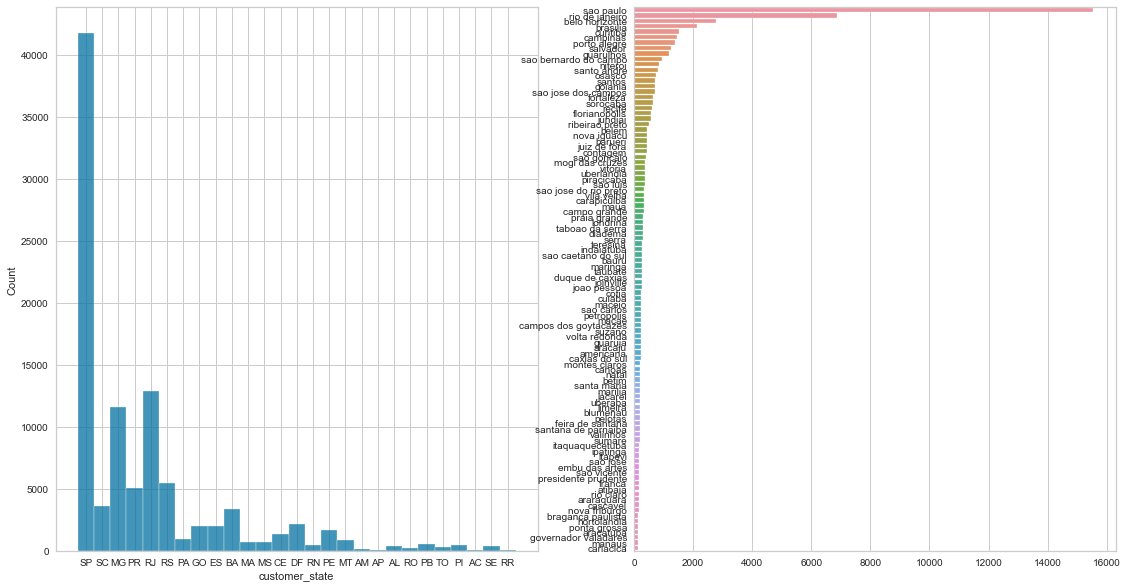

In [284]:
# Affichage du nombre de valeurs uniques en fonction des variable du jeu de données
analyse(data[0])


# Affichage des des histograme de la variable 'customer_state'
plt.figure(figsize = (19,10))
plt.subplot(1, 2, 1)
sns.histplot(x = data[0].customer_state)


# Affichage des des histograme de la variable 'customer_city'
v = data[0].customer_city.value_counts().values[:100] 
i = data[0].customer_city.value_counts().index[:100]
plt.subplot(1,2,2)
sns.barplot(x = v, y = i)
plt.show()

Ce jeu de données contient les contient les informations de localisation des clients (villes et pays). On observe que pour la très grande méjorité des client leurs localisations se situent à Sao Paulo, à Rio des Généro et BelO Horizonte et Bresiliapour 30% du jeu de données et donc essentiellement en Amérique latine. Les clients sont répartis sur 27 pays et 4 119 villes.

Le jeu de donnée contient 99 441 commande pour 96 096 clients uniques.

## Fichier olist_geolocation_dataset

geolocation_zip_code_prefix |  Nombre de lignes uniques :  19015
geolocation_lat |  Nombre de lignes uniques :  717360
geolocation_lng |  Nombre de lignes uniques :  717613
geolocation_city |  Nombre de lignes uniques :  8011
geolocation_state |  Nombre de lignes uniques :  27


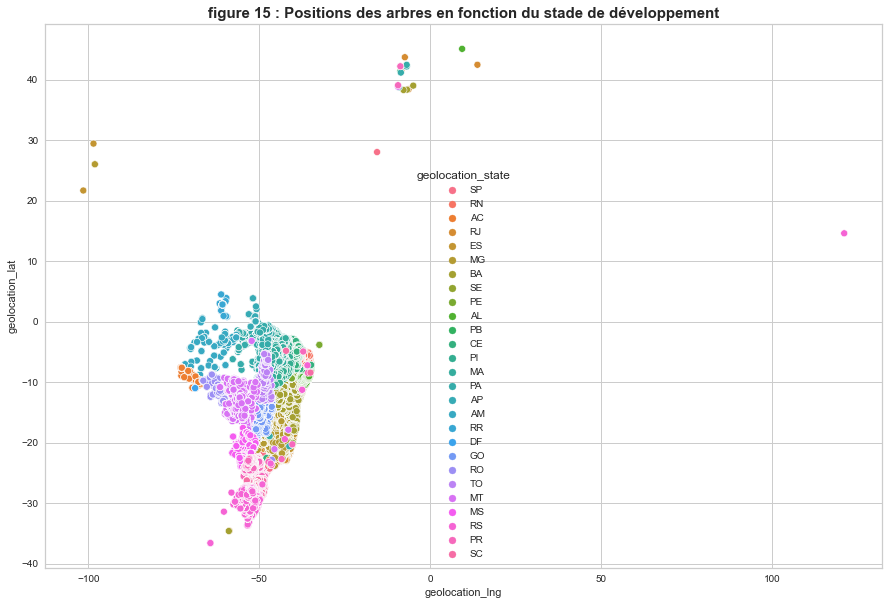

In [285]:
# Affichage du nombre de valeurs uniques en fonction des variable du jeu de données
analyse(data[1])

#Affichage des point de localisation des clients
plt.figure(figsize = (15,10))
sns.scatterplot(y = 'geolocation_lat',
                     x='geolocation_lng',
                     data = data[1],
                     hue = "geolocation_state")
plt.title('figure 15 : Positions des arbres en fonction du stade de développement', 
          fontsize = 15, 
          fontweight = 'bold')
plt.show()

Comme dans présagé dans le jeu de données précédent on remarque bien la répartition des clients en Amérique latine et plus précisément au Brésil.

## Fichier olist_orders_dataset

order_id |  Nombre de lignes uniques :  99441
customer_id |  Nombre de lignes uniques :  99441
order_status |  Nombre de lignes uniques :  8
order_purchase_timestamp |  Nombre de lignes uniques :  98875
order_approved_at |  Nombre de lignes uniques :  90734
order_delivered_carrier_date |  Nombre de lignes uniques :  81019
order_delivered_customer_date |  Nombre de lignes uniques :  95665
order_estimated_delivery_date |  Nombre de lignes uniques :  459


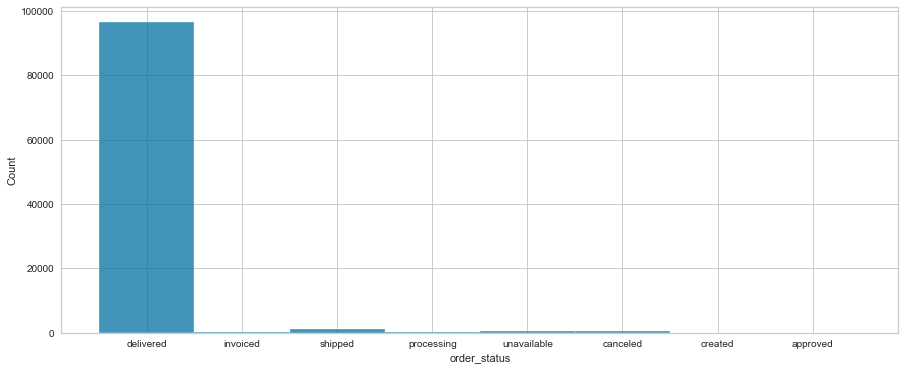

In [295]:
# Affichage du nombre de valeurs uniques en fonction des variable du jeu de données
analyse(data[2])

# Affichage des histograme des status de commande
plt.figure(figsize = (15,6))
sns.histplot(data[2],x = 'order_status')
plt.show()

Le dataset "olist_orders_dataset" contient les informations relatives aux commandes passées par les clients (date de commande date de livraison, etc.). On remarque 97% des commande ont été délivrées, 1,1% sont à l'état expédié et moins 1% sont annulées.

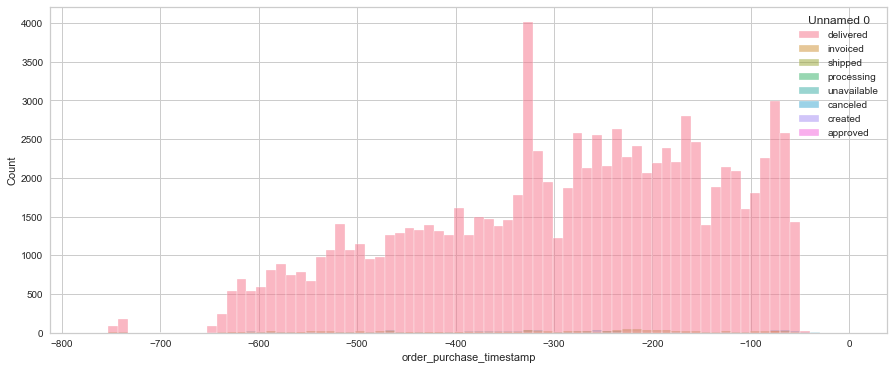

In [333]:
# Affichage de l'histograme de la variable 'order_purchase_timestamp'
d= data[2].order_purchase_timestamp.max()
v = pd.DataFrame([data[2].order_purchase_timestamp.apply(lambda x: [pd.to_datetime(x) - d][0].days), 
              data[2].order_status.values]).T

plt.figure(figsize = (15,6))
sns.histplot(data = v, x = 'order_purchase_timestamp', hue ='Unnamed 0')
plt.show()

Les dates de commande lorsqu'elles sont approuvées s'étallent du 15 septembre 2016 au 3 septembre 2018 soit 718 jours avec un pic de commande aux alentoures de juillet et septembre 2017.

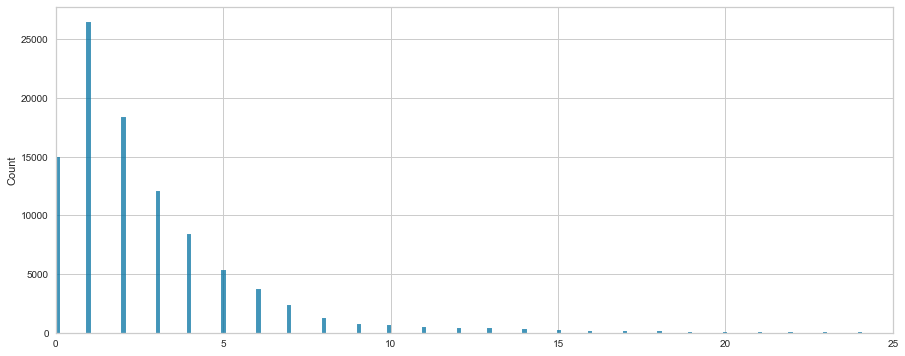

In [408]:
delta = data[2].order_approved_at.apply(lambda x: [pd.to_datetime(x) - d][0].days) - data[2].order_delivered_carrier_date.apply(lambda x: [pd.to_datetime(x) - d][0].days)
plt.figure(figsize=(15,6))
sns.histplot(delta.abs())
plt.xlim(0,25)
plt.show()

Enfin de manière générale le délais entre une commande aprouvée et une commande délivrées se situe entre 0 et 5 jours.

## Fichier olist_order_items_dataset

order_id |  Nombre de lignes uniques :  98666
order_item_id |  Nombre de lignes uniques :  21
product_id |  Nombre de lignes uniques :  32951
seller_id |  Nombre de lignes uniques :  3095
shipping_limit_date |  Nombre de lignes uniques :  93318
price |  Nombre de lignes uniques :  5968
freight_value |  Nombre de lignes uniques :  6999


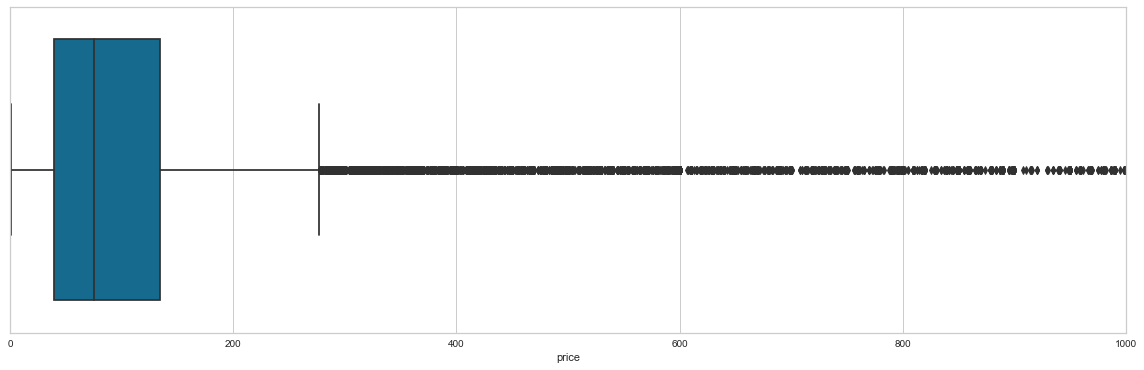

In [414]:
# Affichage du nombre de valeurs uniques en fonction des variable du jeu de données
analyse(data[3])

# Affichage de la boite à moustache de la variable 'price'
plt.figure(figsize = (20,6))
sns.boxplot(data[3].price)
plt.xlim(0, 1000)
plt.show()

Ce dataset quant à lui contient les informations relatives aux produits vendus (prix, types, etc.), ce jeu de donnée recessence 32 951 produits uniques classés en 21 items pour 3095 vendeurs répertoriés et 5968 prix uniques.

Les prix quant à eux s'étalent de 0.85 à 6735.0 avec une moyenne à 120.65.

## Fichier olist_order_payments_dataset

order_id |  Nombre de lignes uniques :  99440
payment_sequential |  Nombre de lignes uniques :  29
payment_type |  Nombre de lignes uniques :  5
payment_installments |  Nombre de lignes uniques :  24
payment_value |  Nombre de lignes uniques :  29077


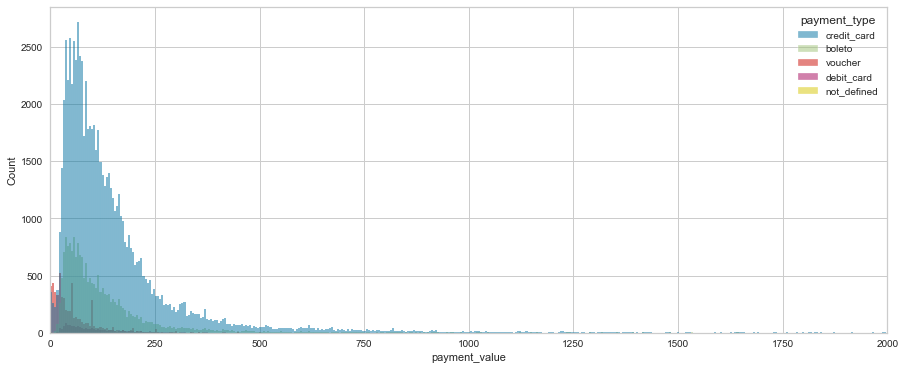

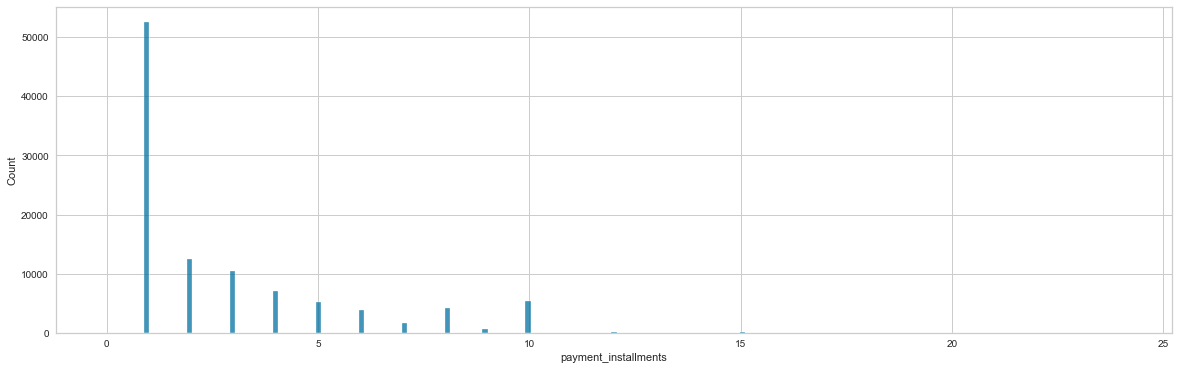

In [416]:
# Affichage du nombre de valeurs uniques en fonction des variable du jeu de données
analyse(data[4])

# Affichage de l'histograme de la variable 'payment_value'
plt.figure(figsize = (15,6))
sns.histplot(data = data[4], x = 'payment_value', hue = 'payment_type')
plt.xlim(0,2000)
plt.show()

# Affichage de l'histograme de la variable 'payment_installments'
plt.figure(figsize = (20,6))
sns.histplot(data[4].payment_installments)
plt.show()

Le jeu de données 'olist_order_payments_dataset' contient les informations relative aux paiement des commandes, leurs types, l'étalonement etc.

75% des paiement ont été réalisé en carte bleu, 19% en billet de banque et 5% en bon d'acaht. Chaque moyen de paiement ayant une moyenne et une répartition des valeurs de paiement différente.


95% des paiement ont été réglé en une fois, 3% en 2 et 0,5 en 3 fois. L'échelonement des paiement quant à lui s'étale de 1 à 29.

## Fichier olist_order_reviews_dataset

review_id |  Nombre de lignes uniques :  99173
order_id |  Nombre de lignes uniques :  99441
review_score |  Nombre de lignes uniques :  5
review_comment_title |  Nombre de lignes uniques :  4601
review_comment_message |  Nombre de lignes uniques :  36922
review_creation_date |  Nombre de lignes uniques :  637
review_answer_timestamp |  Nombre de lignes uniques :  99010


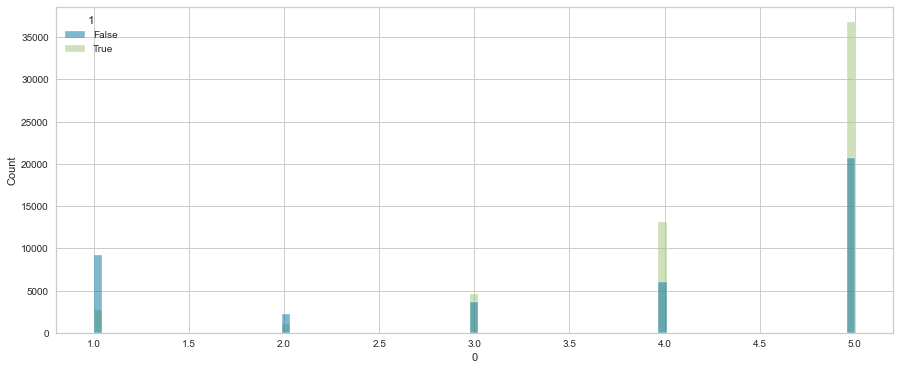

In [369]:
# Affichage du nombre de valeurs uniques en fonction des variable du jeu de données
analyse(data[5])

# Affichage de l'histograme de la variable 'review_score'
l = pd.DataFrame([data[5].review_score.values,data[5].review_comment_message.isna().values]).T
plt.figure(figsize = (15,6))
sns.histplot(data = l, x = 0, hue = 1)
plt.show()

Le jeu de données 'olist_order_reviews_dataset' recenses les avis clients sur leurs commandes passées :
- 57.42% ont reçu 5 étoiles
- 19.2% ont reç 4 étoiles
- 11.85% ont reçu 1 étoile
- 8.287% ont reçu 3 étoiles
- 3.23% ont reçu 2 étoiles

58% des commandes n'ont pas reçu d'avis contre 41%. et demanières générale les client qui emettent des avis ont tendance à mettre de bons scores.

## Fichier olist_products_datase

In [436]:
data[6].product_category_name.value_counts()

cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
casa_conforto_2                     5
fashion_roupa_infanto_juvenil       5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 73, dtype: int64

product_id |  Nombre de lignes uniques :  32951
product_category_name |  Nombre de lignes uniques :  74
product_name_lenght |  Nombre de lignes uniques :  67
product_description_lenght |  Nombre de lignes uniques :  2961
product_photos_qty |  Nombre de lignes uniques :  20
product_weight_g |  Nombre de lignes uniques :  2205
product_length_cm |  Nombre de lignes uniques :  100
product_height_cm |  Nombre de lignes uniques :  103
product_width_cm |  Nombre de lignes uniques :  96


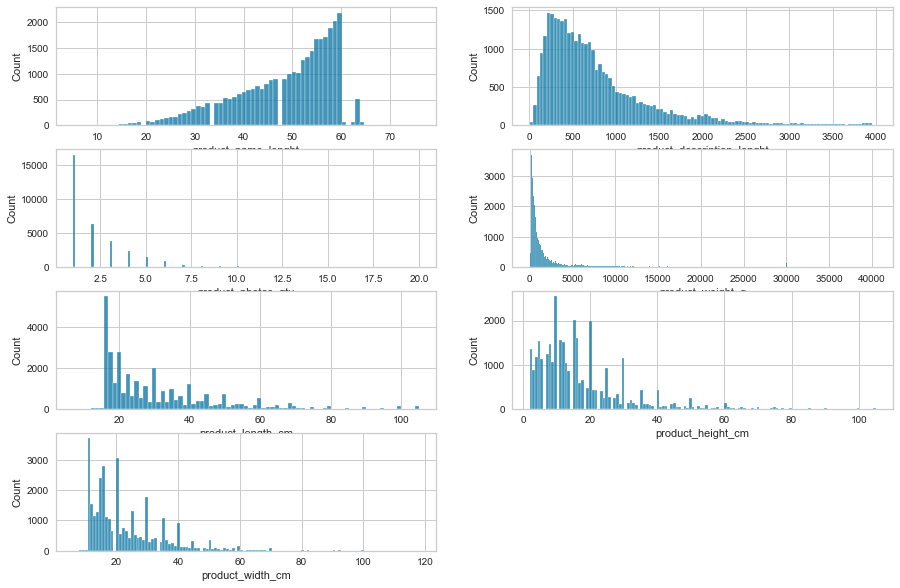

In [378]:
analyse(data[6])
plt.figure(figsize = (15,10))

plt.subplot(4, 2, 1)
sns.histplot(data[6].product_name_lenght)

plt.subplot(4, 2, 2)
sns.histplot(data[6].product_description_lenght)

plt.subplot(4, 2, 3)
sns.histplot(data[6].product_photos_qty)

plt.subplot(4, 2, 4)
sns.histplot(data[6].product_weight_g)

plt.subplot(4, 2, 5)
sns.histplot(data[6].product_length_cm)

plt.subplot(4, 2, 6)
sns.histplot(data[6].product_height_cm)

plt.subplot(4, 2, 7)
sns.histplot(data[6].product_width_cm)
plt.show()

Le jeu de données olist_products_datase recessent les données relatives aux caractéristique physiques des produits ainsi qu'aux types de produits.

## Fichier olist_sellers_dataset

seller_id |  Nombre de lignes uniques :  3095
seller_zip_code_prefix |  Nombre de lignes uniques :  2246
seller_city |  Nombre de lignes uniques :  611
seller_state |  Nombre de lignes uniques :  23


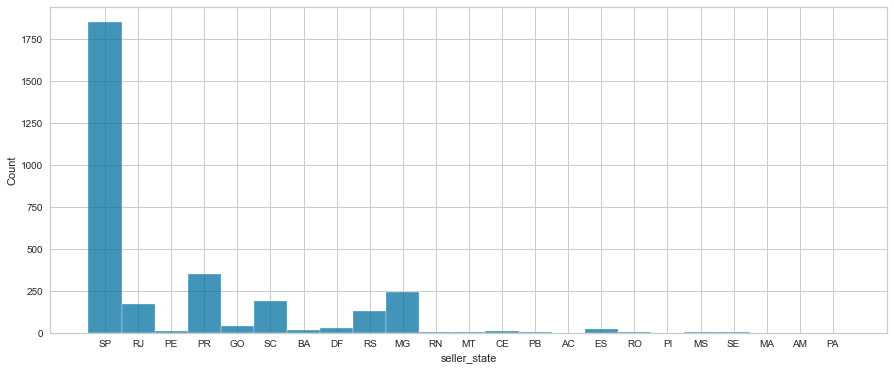

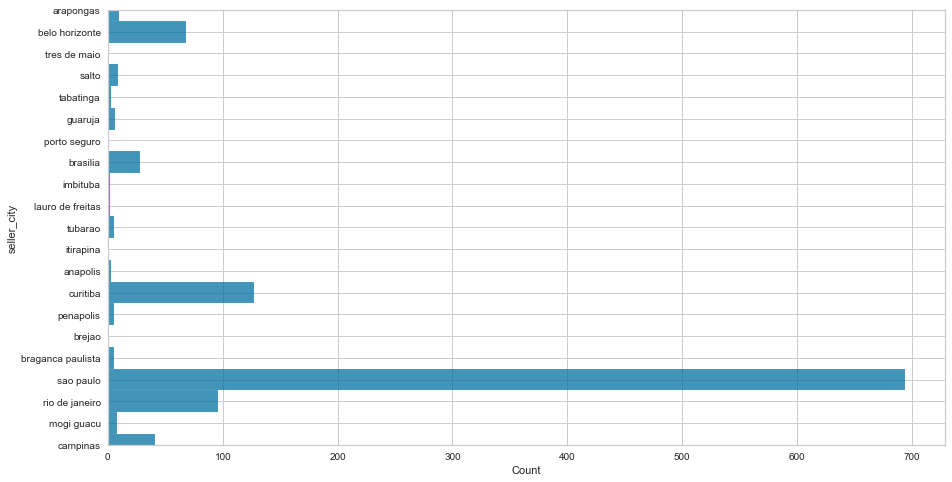

In [389]:
analyse(data[7])

plt.figure(figsize = (15, 6))
sns.histplot(data[7].seller_state)
plt.show()

plt.figure(figsize = (15,8))
sns.histplot(y = data[7].seller_city)
plt.ylim(0, 20)
plt.show()

Enfin, le dernier jeu de données nous donne des informations concernant les villes des vendeurs, 22% étaient situés à Sao Paulo et 3095 vendeurs sont recenssés.

<b>Conclusion</b>

L'ensemble des données son cohérentes et délivrent des informations pertinentes sur les vendeurs, les commandes passées ainsi que sur les client et leurs mode de paiement. 

Nous avons remarqué que d'un jeu de données à l'autre nous n'avons le même nombre de d'information, notament sur le nombre de vendeur ou de client.

Par la suite nous regrouperons l'ensemble des donnée dans un seul et même dataset et nétoireons les information dupliquées, abérente et effaceront les ligne contenant trop d'information manquantes.
Nous avons sufisament de données pour réaliser notre classification.

# Data Engineering

Nous avons pu observer l'ensemble de nos données ainsi que le répartion, à présent nous allons procéder à l'ajustement de nos variables afin de les préparer pour nos modèles de classification.

Nous procéderont en 3 grandes étapes :
- 1. Nous fusionnerons l'ensemble des fichiers dans un sel et même jeu de données, nous nétoierons par la même occasion les données manquantes, dupliquées et/ou abérentes.
- 2. Nous crérons un dataset disctinct du premier composées de trois variables Recency, qui regroupera le nombre de commande passé par chaque client, Frequency, le temps en jour de la dernière commande du cllient, et Monetary, la somme globale dépensé par le client chez Olist.
- 3. Enfin nous procéderons à une réduction de dimension sur le premier jeu de données via la méthode de la projection par l'analyse en composante principale (ACP)

Une fois ces préparatifs achevés nous étudierons quels sont les approche de clustering les mieux adaptés à notre problématique et quel jeux de données fournis la meilleur base pour notre clustrisation.

## Regroupement des dataset (jeux de données) & Data cleaning

In [3]:
# Modification de la vraible 'geolocation_zip_code_prefix'
for u in data[1]['geolocation_zip_code_prefix'].unique():
    data[1].loc[data[1].geolocation_zip_code_prefix == u, 'geolocation_lng'] = data[1].loc[data[1].geolocation_zip_code_prefix == u, 'geolocation_lng'].mean()
    data[1].loc[data[1].geolocation_zip_code_prefix == u, 'geolocation_lat'] = data[1].loc[data[1].geolocation_zip_code_prefix == u, 'geolocation_lat'].mean()

data[1]['customer_zip_code_prefix'] = data[1]['geolocation_zip_code_prefix']


# Fusion de l'ensemble des jeux de données dans la variable df
f1 = pd.merge(data[2],data[3])

f2 = pd.merge(f1, data[4])

f3 = pd.merge(f2, data[5])

f4 = pd.merge(f3, data[6])

f5 = pd.merge(f4, data[7])

df = pd.merge(f5, data[0])

df = pd.merge(df,data[1].drop_duplicates())

In [4]:
df = df.drop_duplicates(['order_id'])

# Modification des variable de type date au format datetime
for u in ['order_purchase_timestamp',
          'order_approved_at',
          'order_delivered_carrier_date',
          'order_delivered_customer_date',
          'order_estimated_delivery_date',
         'shipping_limit_date',
         'review_creation_date',
         'review_answer_timestamp']:
    x = pd.to_datetime(df[u]) - pd.to_datetime(df[u]).max()
    x = x.apply(lambda x: -x.days)
    df[u] = x

# Suppression des valeurs nulles
df = df.dropna()

# Suppression des variable relative au identifiants
df = df.drop(['order_id','product_id','seller_id','review_id',
        'geolocation_state','customer_state','customer_city','seller_city','seller_state','geolocation_city'], axis=1)

# Remplacement des valeurs manquantes par des 0
df.review_comment_message = df.review_comment_message.fillna(0)
df.review_comment_title = df.review_comment_title.fillna(0)

#  Remplacement des commentaire par 1: s'il y a un commentaire, 0: s'il n'y a pas de commentaire 
def comment(x):
    if x !=0: return 1
    else : return x
    
df['review_comment_message'] = df.review_comment_message.apply(lambda x: comment(x))
df['review_comment_title'] = df.review_comment_title.apply(lambda x: comment(x))

In [5]:
# Import du module d'encodage
from sklearn.preprocessing import OneHotEncoder

# Encodage des variables catégirielles
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit_transform(df.order_status.values.reshape(-1,1)).toarray()
enc.get_feature_names(['order_status'])
order_status = pd.DataFrame(enc.fit_transform(df.order_status.values.reshape(-1,1)).toarray(),
                            columns = enc.get_feature_names(['order_status']))

# Regroupement des variable encodées avec le jeu de données principal
df = pd.concat([df,order_status], axis = 1)
df = df.drop(['order_status'], axis=1)

# Encodage des variables catégirielles
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit_transform(df.payment_type.values.reshape(-1, 1)).toarray()
enc.get_feature_names(['payment_type'])
payment_type = pd.DataFrame(enc.fit_transform(df.payment_type.values.reshape(-1, 1)).toarray(),
                            columns = enc.get_feature_names(['payment_type']))

# Regroupement des variable encodées avec le jeu de données principal
df = pd.concat([df,payment_type], axis = 1)
df  = df.drop(['payment_type'], axis=1)

# Création de la variable 'Date_m' qui transforme la date de livraison en mois
df["Date_m"] = df_.order_delivered_customer_date//30
df = df.sort_values('Date_m').reset_index()

# Suppression des variables inutiles
df = df.drop(['index','product_category_name','customer_zip_code_prefix','seller_zip_code_prefix','geolocation_zip_code_prefix'], axis=1)
df_ = df.drop(['customer_id', 'customer_unique_id'], axis = 1)

## Features Engineering : Réduction de dimension (Méthode ACP)

In [441]:
# import des module de réduction de dimension en analyse en composante principale
from sklearn.decomposition import PCA

# Décomposition du jeu de données principale en 2 axes d'inertie
pca = PCA(n_components=2)
pca.fit(df_)
print(f"La réduction de dimension concervera en pourcentage : {pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]} de l'inertie total")
df_pca = pca.transform(df_)
df_pca = pd.DataFrame(df_pca)

# Création de la variable date_m
df_pca["Date_m"] = df_.order_delivered_customer_date//30
df_pca = df_pca.sort_values('Date_m').reset_index()

La réduction de dimension concervera en pourcentage : 0.9827991398088664 de l'inertie total


## Features Engineering : Création des variables RFM

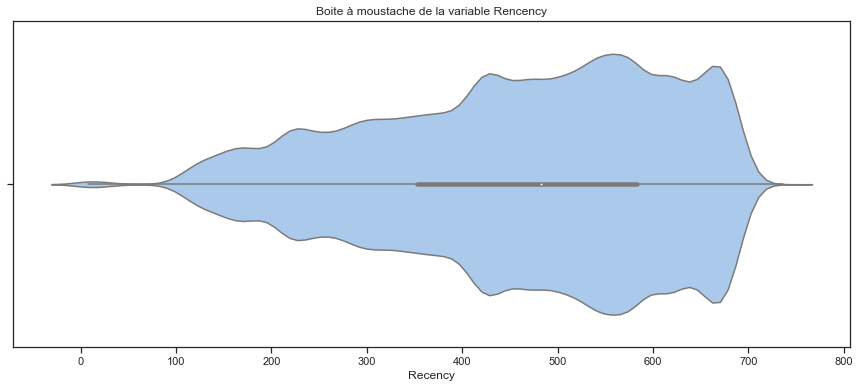

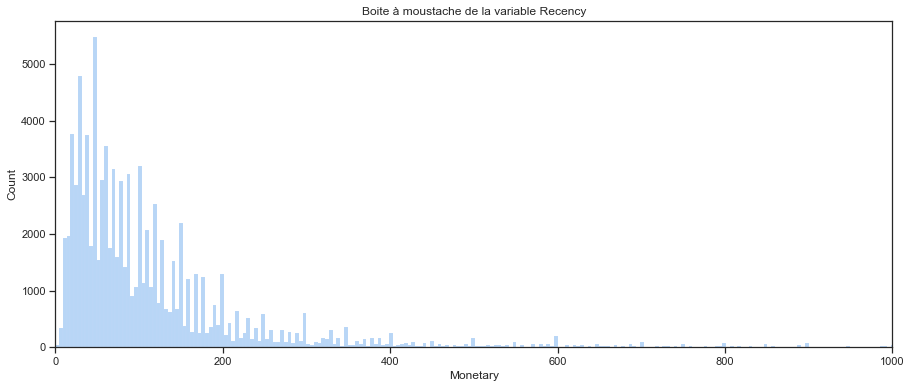

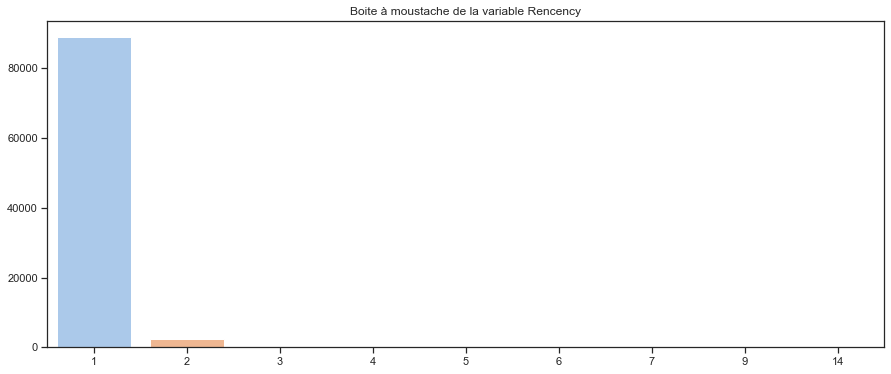

In [60]:
# Création des variables RFM
RFM = []
day_max = df.order_delivered_customer_date.max()
for client in df.customer_unique_id.value_counts().index:
    data_tmp = df[df.customer_unique_id == client]
    freq = len(data_tmp)
    sum_price = data_tmp.price.sum()
    day = data_tmp.order_delivered_customer_date - day_max
    RFM.append([client, int(-day.min()),int(freq), int(sum_price)])

# Créatio du dataset RFM
RFMScores = pd.DataFrame(RFM, columns = ['CustomerID','Recency', 'Frequency', 'Monetary'])

# Affichage du graphe violon de la variable Recency
sns.set_theme(style = "ticks", palette = "pastel")
plt.figure(figsize = (15, 6))
plt.title('Boite à moustache de la variable Rencency')
sns.violinplot(RFMScores.Recency)
plt.show()

# Affichage de l'histograme de la variable 'Monetary'
plt.figure(figsize = (15, 6))
plt.title('Boite à moustache de la variable Recency')
sns.histplot(RFMScores.Monetary)
plt.xlim(0, 1000)
plt.show()

# Affichage de l'histograme de la variable 'Frequency'
plt.figure(figsize = (15, 6))
plt.title('Boite à moustache de la variable Rencency')
sns.barplot(x = RFMScores.Frequency.value_counts().index, 
            y = RFMScores.Frequency.value_counts().values,)
plt.show()

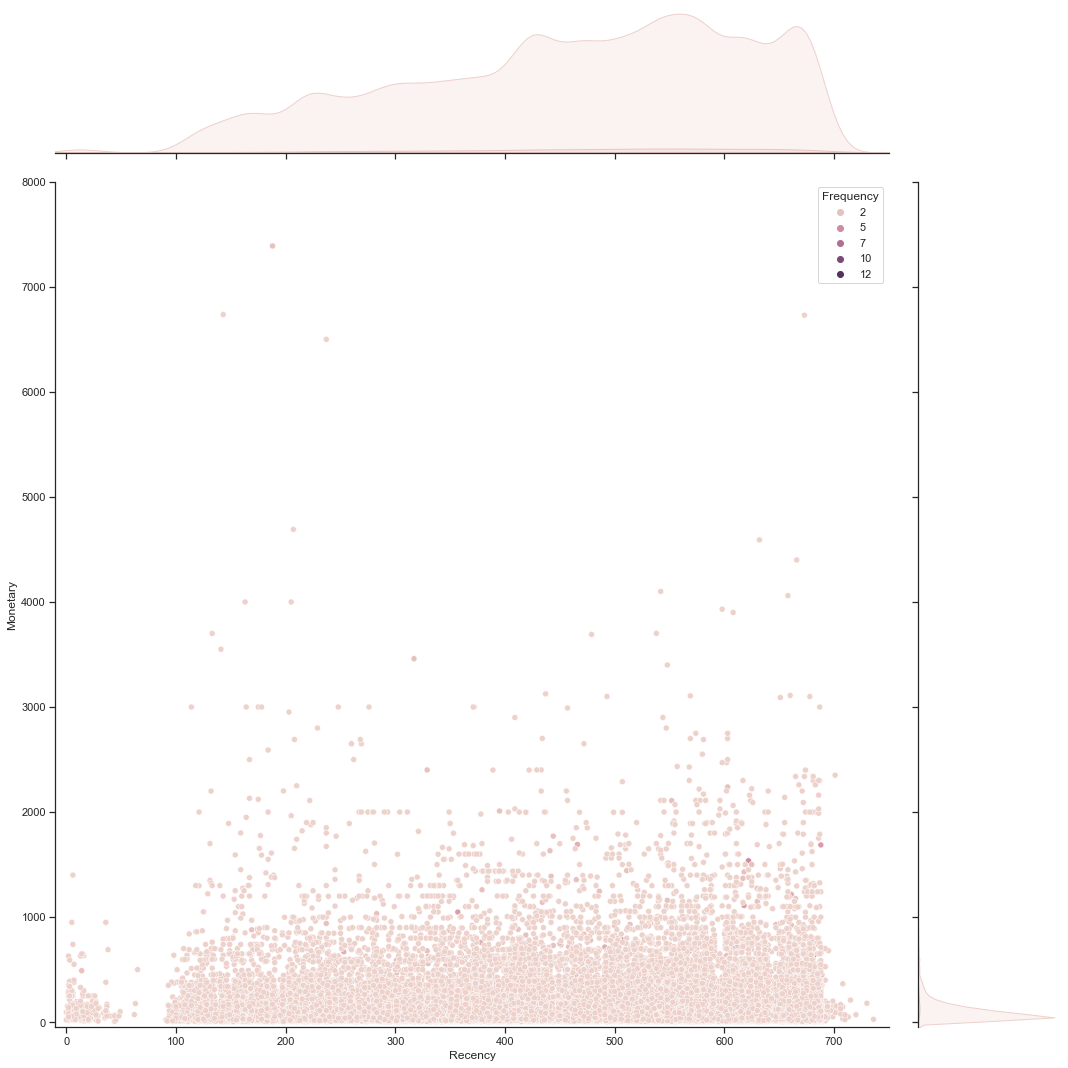

In [59]:
# Affichage de la réartion des points en fonction des variables 'Recency' et 'Monetary'
sns.jointplot(
    data = RFMScores,
    color = 'r',
    x = "Recency", 
    y = "Monetary",
    hue = 'Frequency',
    height = 15,
    xlim = (-10, 750),
    ylim = (-50, 8000))
plt.show()

# Sélection des modèles de clustering

Nous avons réaliser le nétoyage et la création des features qui seront utilisés dans nos modèles de classification. A présent, dans cette artie nous veront 4 proches différentes pour la classification de nos clients : 
- 1. L'approche RFM, qui consiste à classer nos clients en fonction des 3 variable Recency, Freqency et Monetary crées précédement.
- 2. L'approche 'Clustering Hierarchique' qui consiste a regrouper successicement nos client dans des groups de plus en plus concéquent.
- 3. L'approche DBSCAN qui permet de trouver des cluster non convexe
- 4. L'approche K-means qui permet de rechercher efficacement une partition des données dont la variance intra-cluster est minimale

A l'issue de l'application de ces 4 approche nous concluerons sur celle qui correspond le mieu à notre problématique.

Pour la comparaison de nos modèle nous utiliserons 3 métriques :
- Le coeficient sihlouette :

- Le coeficent David Bouldin :

- Le score Rand :

In [442]:
# Import des différents score de métric
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

## Approche RFM
L'approche RFM (Recency : , Frequency, Monetarie) consiste à

In [109]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

RFMScores = RFMScores[(RFMScores.Recency != 'nan') & (RFMScores.Frequency != 'nan') & (RFMScores.Monetary != 'nan')]

RFMScores.Recency = RFMScores.Recency.apply(lambda x: int(x))
RFMScores.Frequency = RFMScores.Frequency.apply(lambda x: int(x))
RFMScores.Monetary = RFMScores.Monetary.apply(lambda x: float(x))

quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()


#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))


#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores = RFMScores.reset_index().drop(['index'], axis = 1)

#Création du dataset RFM
RFM = RFMScores[['Recency','Frequency','Monetary']]
RFMScores.groupby('RFM_Loyalty_Level').mean()

,level_0,Recency,Frequency,Monetary,R,F,M,RFMScore
RFM_Loyalty_Level,,,,,,,,
Platinum,43778.074830,364.703620,1.085153,205.056900,1.731052,3.770419,1.686934,7.188405
Gold,47289.809249,454.963607,1.001110,126.000754,2.445145,3.996671,2.558184,9.000000
Silver,47482.974861,532.962322,1.000000,65.071953,2.988595,4.000000,3.011405,10.000000
Bronze,46926.099645,605.313843,1.000000,38.050609,3.663794,4.000000,3.665599,11.329393


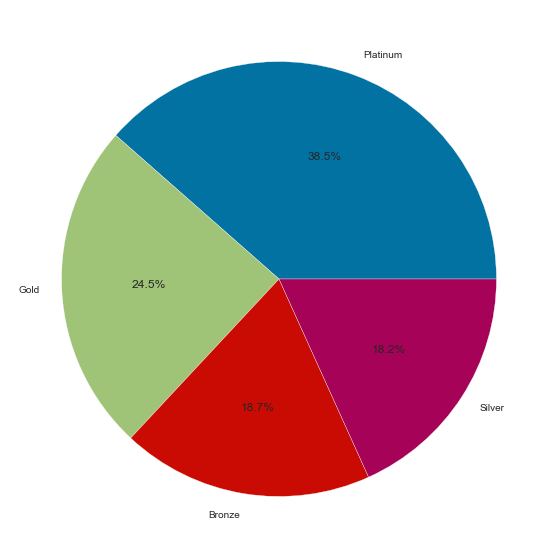

Platinum


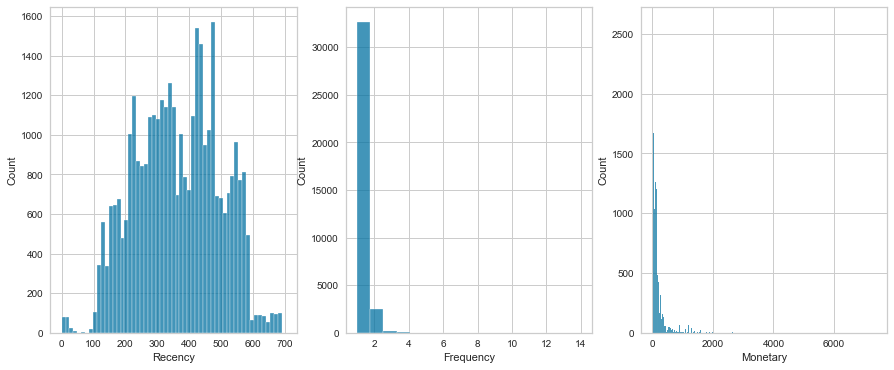

Gold


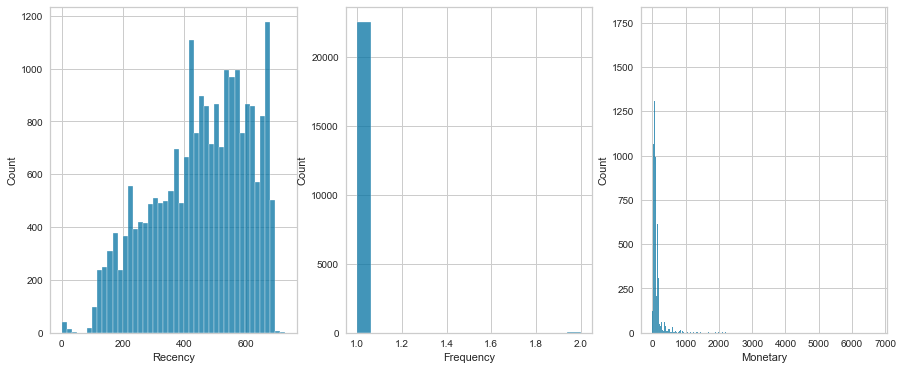

Silver


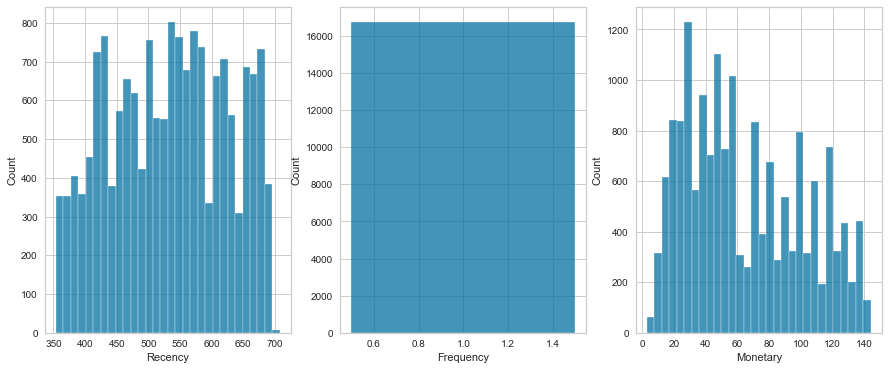

Bronze


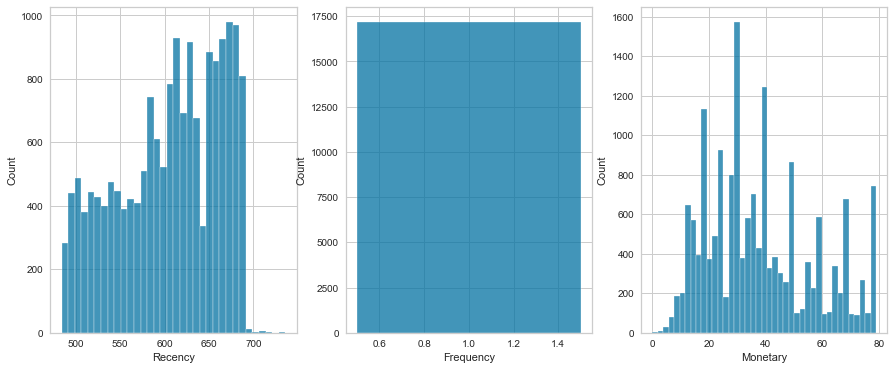

In [443]:
# Affichage du camembert des cluster créer par RFM
plt.figure(figsize=(10,10))
plt.pie(RFMScores.RFM_Loyalty_Level.value_counts(),
        autopct='%1.1f%%',
        labels=RFMScores.RFM_Loyalty_Level.value_counts().index)
plt.show()

# Affichage des différentes répartion en fonction de la classification des clients
for u in RFMScores.RFM_Loyalty_Level.unique():
    print(u)
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(RFMScores[RFMScores.RFM_Loyalty_Level == u].Recency)

    plt.subplot(1, 3, 2)
    sns.histplot(RFMScores[RFMScores.RFM_Loyalty_Level == u].Frequency)


    plt.subplot(1, 3, 3)
    sns.histplot(RFMScores[RFMScores.RFM_Loyalty_Level == u].Monetary)
    plt.show()

# Calcul des score david bouldin et de sihlouette
RFM_sil_score = silhouette_score(RFM, RFMScores.RFM_Loyalty_Level)
RFM_dv_score = davies_bouldin_score(RFM, le.fit_transform(RFMScores.RFM_Loyalty_Level))

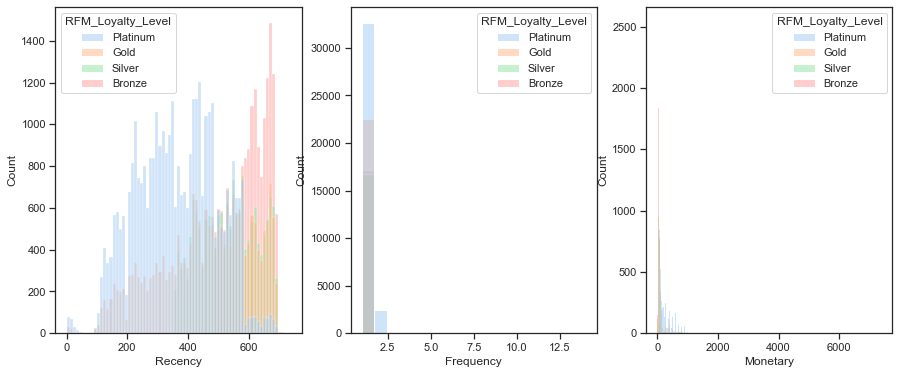

In [119]:
# Affichage de l'histograme de la variable 'Rencency'
plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
sns.histplot(data = RFMScores, x = 'Recency', hue = 'RFM_Loyalty_Level')

# Affichage de l'histograme de la variable 'Frequency'
plt.subplot(1, 3, 2)
sns.histplot(data = RFMScores, x = 'Frequency', hue = 'RFM_Loyalty_Level')

# Affichage de l'histograme de la variable 'Monetary'
plt.subplot(1, 3, 3)
sns.histplot(data = RFMScores, x = 'Monetary', hue = 'RFM_Loyalty_Level')
plt.show()

## Approche Clustering Hiérarchique

<img src='https://user.oc-static.com/upload/2017/05/12/14946030170438_P3C3-1.png'>

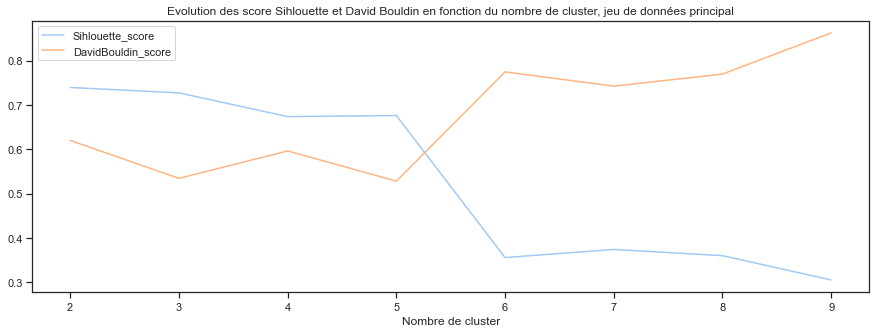

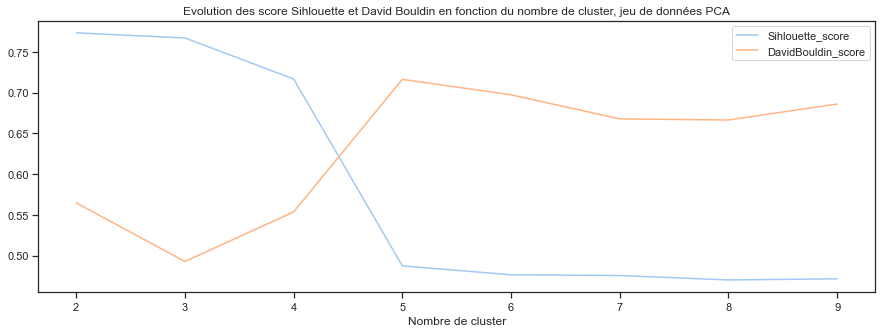

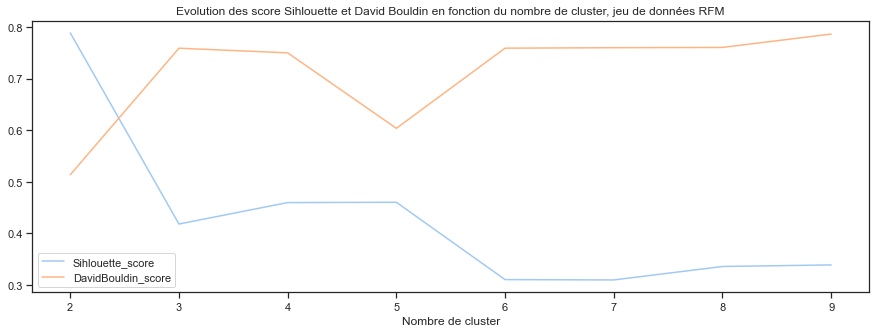

In [145]:
# Import du module de classification hierarchique
from sklearn.cluster import AgglomerativeClustering

# Définition de la fonction d'évaluation des score david bouldin et sihlouette en fonction du nombre de cluster
def n_cluster(df, estimateur, n=None, T=False, données=None):
    
    s = []
    for u in range(2, 10):
        clustering = estimateur(n_clusters = u)
        pred = clustering.fit_predict(df[:n])
        s.append([silhouette_score(df[:n], pred),davies_bouldin_score(df[:n], pred)])
        if T:
            print(u)
    plt.figure(figsize = (15, 5))
    plt.title(f'Evolution des score Sihlouette et David Bouldin en fonction du nombre de cluster, jeu de données {données}')
    plt.plot(range(2,10),s)
    plt.legend(['Sihlouette_score','DavidBouldin_score'])
    plt.xlabel('Nombre de cluster')
    plt.show()
    return

# Affichage des score en fonction des trois jeux de données
n_cluster(df_, AgglomerativeClustering, 10000, données = 'principal')
n_cluster(df_pca[[0,1]], AgglomerativeClustering, 10000, données = 'PCA')
n_cluster(RFM, AgglomerativeClustering, 10000, données = 'RFM')

Observations

In [ ]:
def score_bydf(df_, model):
    if model == 'DBSCAN':
        clustering = DBSCAN(eps = 13, min_samples = 5).fit(df_pca[:10000])
        pred_ = clustering.fit_predict(df_[:10000])
        return [silhouette_score(df_[:10000], pred_), davies_bouldin_score(df_[:10000], pred_)]
    
    elif model == 'Agglomerative':
        clustering = AgglomerativeClustering(n_clusters = 6)
        pred_ = clustering.fit_predict(df_[:10000])
        return [silhouette_score(df_[:10000], pred_), davies_bouldin_score(df_[:10000], pred_)]
    
    elif model == 'KMEANS':
        clustering = KMeans(n_clusters=6)
        pred_ = clustering.fit_predict(df_[:10000])
        return [silhouette_score(df_[:10000], pred_), davies_bouldin_score(df_[:10000], pred_)]

def plot_score(score):
    # Affichage des score sur un graphique
    labels = ['Principa', 'ACP', 'RFM']
    Sihlouette_score = pd.DataFrame(score, columns = ['Sihlouette_score','DavideBouldin_score']).Sihlouette_score
    DavideBouldin_score = pd.DataFrame(score, columns = ['Sihlouette_score','DavideBouldin_score']).DavideBouldin_score

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, Sihlouette_score, width, label = 'Sihlouette_score')
    rects2 = ax.bar(x + width/2, DavideBouldin_score, width, label = 'DavideBouldin_score')
    ax.set_ylabel('Scores')
    ax.set_title('Scores méthode de sélection des données')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

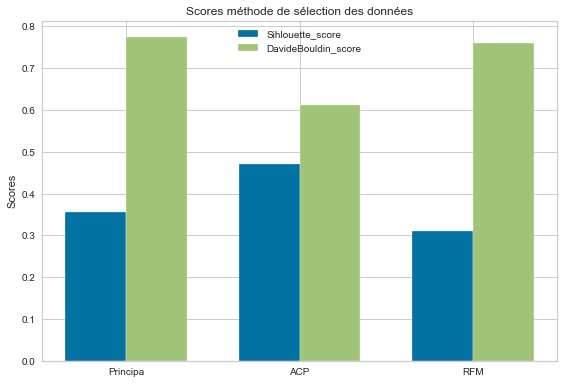

In [474]:
test1 = [score_bydf(df_, 'Agglomerative'),score_bydf(df_pca, 'Agglomerative'),score_bydf(RFM, 'Agglomerative')]
plot_score(test1)

Observations

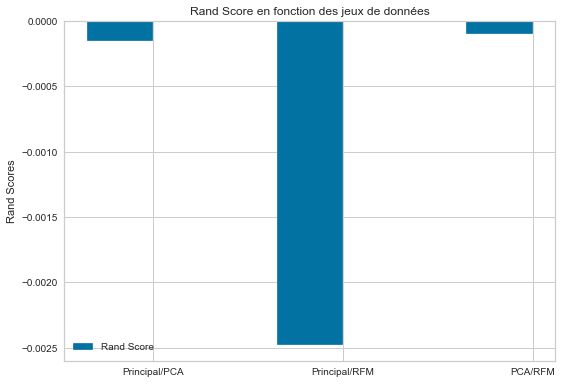

In [446]:
# Comparaison des cluster avec l'indice Rand score
labels = ['Principal/PCA', 'Principal/RFM', 'PCA/RFM']
men_means = [adjusted_rand_score(pred_ag, pred_pca_ag), 
             adjusted_rand_score(pred_ag, pred_rfm_ag),
             adjusted_rand_score(pred_pca_ag, pred_rfm_ag)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label = 'Rand Score')

# Affichage des score sur graphiquue
ax.set_ylabel('Rand Scores')
ax.set_title('Rand Score en fonction des jeux de données')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

Observations

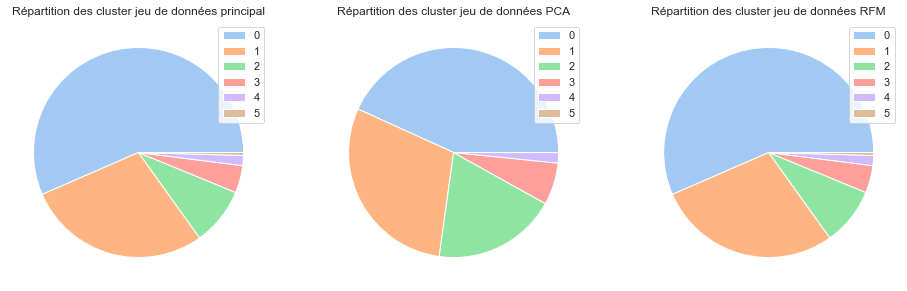

In [144]:
#
plt.figure(figsize = (16, 10))
plt.subplot(1, 3, 1)
plt.pie(pd.DataFrame(pred_ag).value_counts())
plt.title('Répartition des cluster jeu de données principal')
plt.legend(range(6))

#
plt.subplot(1, 3, 2)
plt.pie(pd.DataFrame(pred_rfm_ag).value_counts())
plt.title('Répartition des cluster jeu de données PCA')
plt.legend(range(6))

#
plt.subplot(1, 3, 3)
plt.pie(pd.DataFrame(pred_ag).value_counts())
plt.title('Répartition des cluster jeu de données RFM')
plt.legend(range(6))
plt.show()

Observations

## Approche DBSCAN

<img src='https://user.oc-static.com/upload/2017/05/12/1494605250012_P3C5-4.png'>

In [152]:
# Import du module de classification DBSCAN
from sklearn.cluster import DBSCAN

# Création de la fonction d'évaluation des scores en fonction des hypers paramètres du module DBSCAN
def n_clust_dbscan(df_pca, n, x=5):
    n_clust = [[0 for u in range(1,n)] for i in range(1,n)]
    n_dv = [[0 for u in range(1,n)] for i in range(1,n)]
    n_sil = [[0 for u in range(1,n)] for i in range(1,n)]
    for i in range(1,n):

        for u in range(x,n):
            clustering = DBSCAN(eps = i, min_samples = u).fit(df_pca[:10000])
            n_clust[i-1][u-1] = pd.DataFrame(clustering.labels_)[0].nunique()
            if n_clust[i-1][u-1] > 2:
                n_dv[i-1][u-1] = davies_bouldin_score(df_pca[:10000], clustering.labels_)
                n_sil[i-1][u-1] = silhouette_score(df_pca[:10000], clustering.labels_)
    # en x+1  :min_samples
    # en y+1 epsilon
    plt.figure(figsize = (15, 10))
    sns.heatmap(pd.DataFrame(n_clust).iloc[:,x:], annot = True, fmt="d", cmap="YlGnBu")
    plt.title('Heatmap du nombre de cluster en fonction des hyper-paramètres')
    plt.xlabel('hyper-paramètre : min_samples')
    plt.ylabel('hyper-paramètre : epsilon')
    
    plt.show()

    plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(n_dv).iloc[:, x:], annot = True)
    plt.title('Heatmap du score david bouldin en fonction des hyper-paramètres')
    plt.xlabel('hyper-paramètre : min_samples')
    plt.ylabel('hyper-paramètre : epsilon')
    
    
    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(n_sil).iloc[:, x:], annot = True)
    plt.title('Heatmap du sihlouette score en fonction des hyper-paramètres')
    plt.xlabel('hyper-paramètre : min_samples')
    plt.ylabel('hyper-paramètre : epsilon')
    
    plt.show()

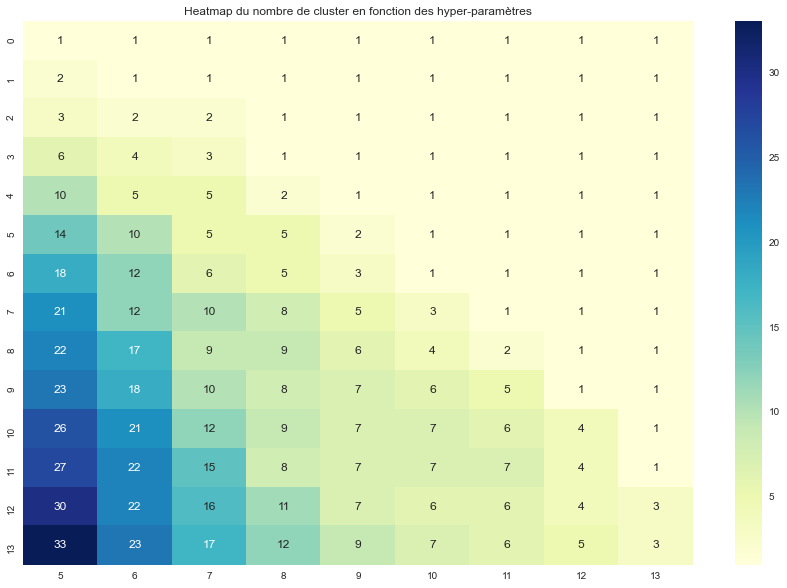

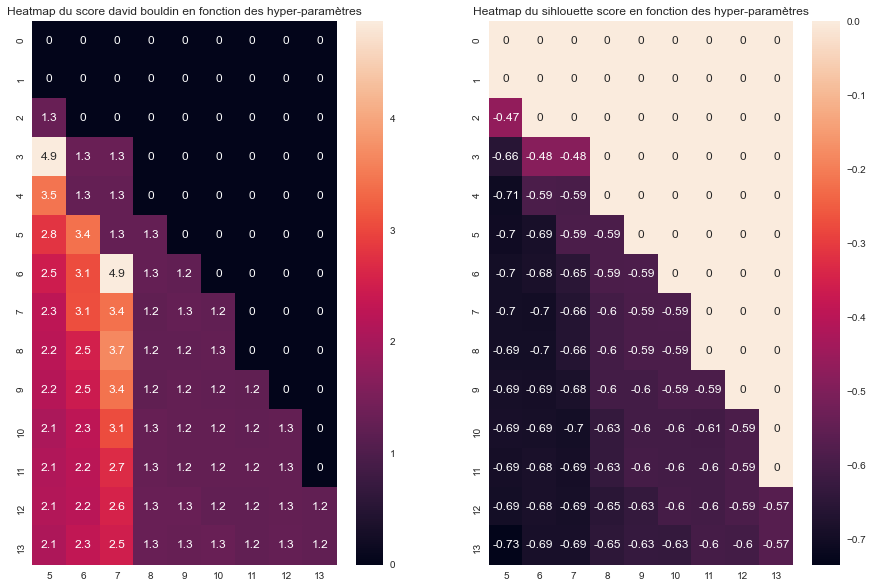

In [516]:
n_clust_dbscan(df_pca, n = 15)

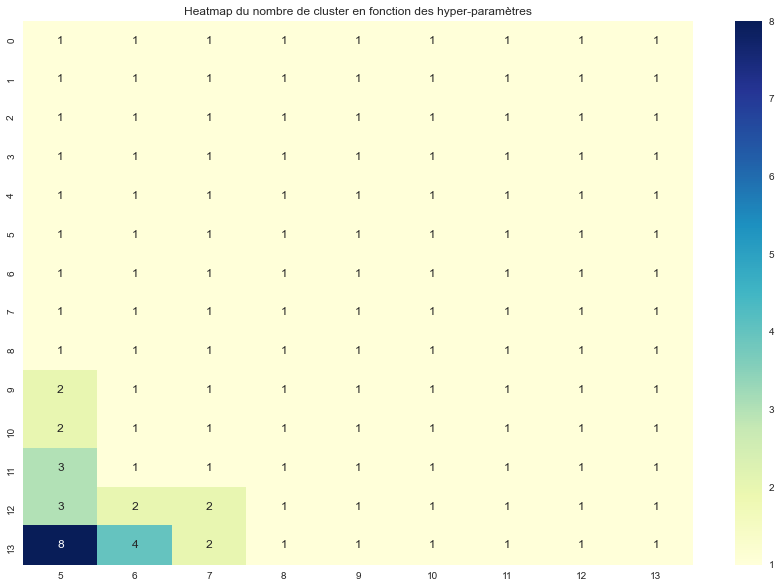

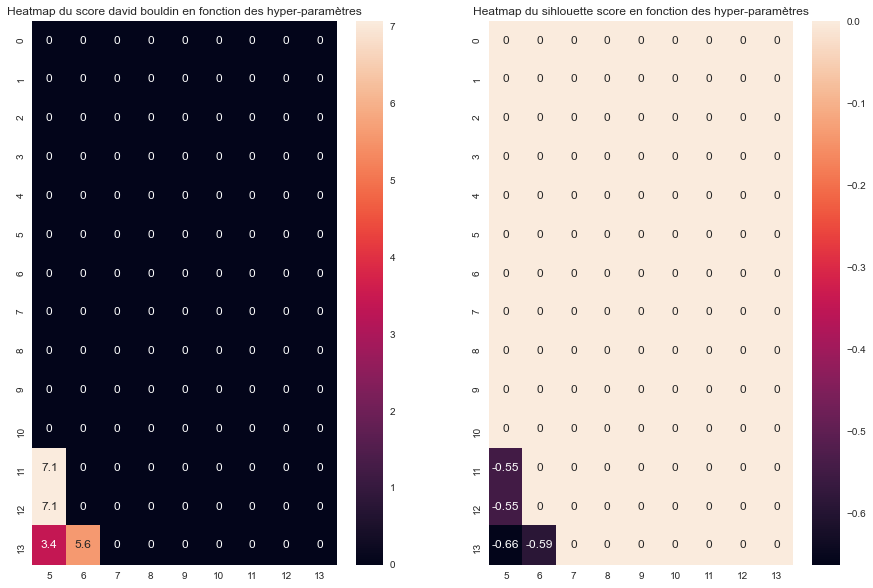

In [522]:
n_clust_dbscan(df_, n = 15)

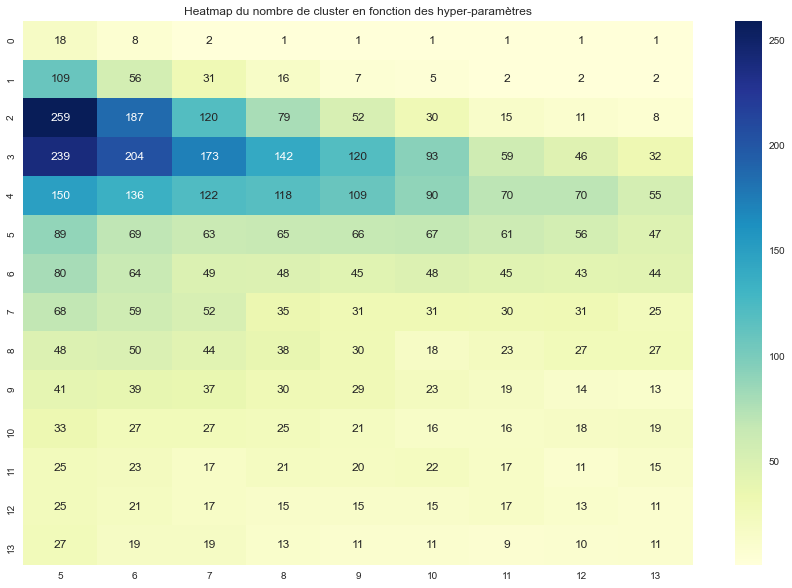

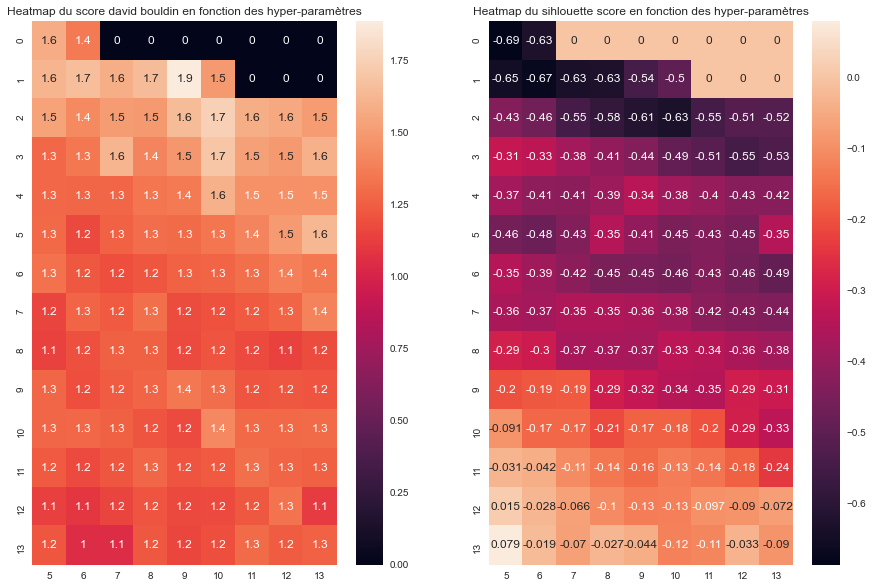

In [523]:
n_clust_dbscan(RFM, n = 15)

In [217]:
# Affichage de la répartion des clusters en fonction des hypers-paramètres du modul DBSCAN
@widgets.interact(epsilon = (2, 15, 1), min_samples = (2, 15, 1))
def pca(epsilon = 6, min_samples = 8):
    clustering = DBSCAN(eps=epsilon, min_samples = min_samples).fit(df_[:10000])
    pd.DataFrame(clustering.labels_)[0].nunique()
    plt.pie(pd.DataFrame(clustering.labels_).value_counts())
    plt.show()

interactive(children=(IntSlider(value=6, description='epsilon', max=15, min=2), IntSlider(value=8, description…

In [465]:
def score_bydf(df_):
    clustering = DBSCAN(eps = 13, min_samples = 5).fit(df_pca[:10000])
    pred_ = clustering.fit_predict(df_[:10000])
    
    return [silhouette_score(df_[:10000], pred_), davies_bouldin_score(df_[:10000], pred_)]

def plot_score(score):
    # Affichage des score sur un graphique
    labels = ['Principa', 'ACP', 'RFM']
    Sihlouette_score = pd.DataFrame(score, columns = ['Sihlouette_score','DavideBouldin_score']).Sihlouette_score
    DavideBouldin_score = pd.DataFrame(score, columns = ['Sihlouette_score','DavideBouldin_score']).DavideBouldin_score

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, Sihlouette_score, width, label = 'Sihlouette_score')
    rects2 = ax.bar(x + width/2, DavideBouldin_score, width, label = 'DavideBouldin_score')
    ax.set_ylabel('Scores')
    ax.set_title('Scores méthode de sélection des données')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [469]:
test = [score_bydf(df_), score_bydf(df_pca), score_bydf(RFM)]

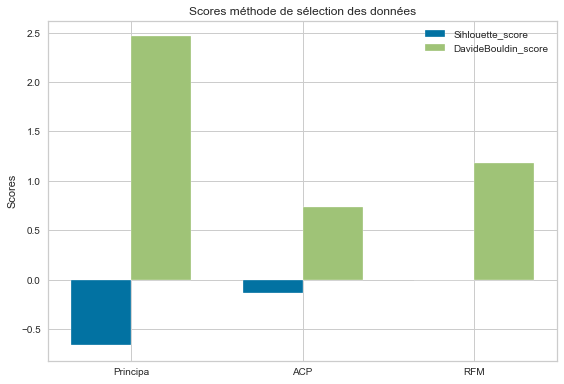

In [470]:
plot_score(test)

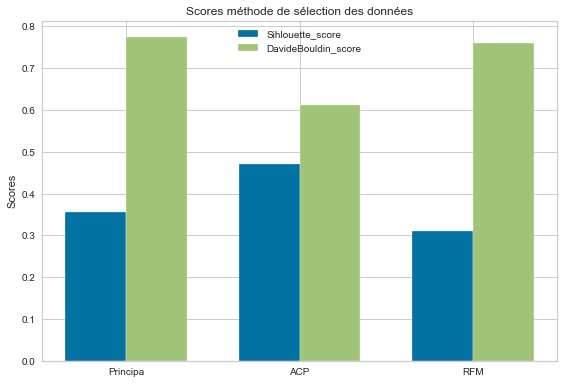

In [448]:
# Affichage des score david bouldin et sihlouette en fonction du jeu de données RFM
score__dbscan = []
clustering = DBSCAN(eps = 3, min_samples = 5).fit(df_pca[:10000])
pred_dbscan = clustering.fit_predict(df_[:10000])
score__dbscan.append([silhouette_score(df_[:10000], pred_dbscan),
               davies_bouldin_score(df_[:10000], pred_dbscan)])

# Affichage des score david bouldin et sihlouette en fonction du jeu de données RFM
clustering = DBSCAN(eps = 3, min_samples = 5).fit(df_pca[:10000])
pred_pca_dbscan = clustering.fit_predict(df_pca[:10000])
score__dbscan.append([silhouette_score(df_pca[:10000], pred_pca_ag),
               davies_bouldin_score(df_pca[:10000], pred_pca_ag)])

# Affichage des score david bouldin et sihlouette en fonction du jeu de données RFM
clustering = DBSCAN(eps = 3, min_samples = 5).fit(df_pca[:10000])
pred_rfm_dbscan = clustering.fit_predict(RFM[:10000])
score__dbscan.append([silhouette_score(RFM[:10000], pred_rfm_ag),
               davies_bouldin_score(RFM[:10000], pred_rfm_ag)])


# Affichage des score sur un graphique
labels = ['Principa', 'ACP', 'RFM']
Sihlouette_score = pd.DataFrame(score__dbscan, columns = ['Sihlouette_score','DavideBouldin_score']).Sihlouette_score
DavideBouldin_score = pd.DataFrame(score__dbscan, columns = ['Sihlouette_score','DavideBouldin_score']).DavideBouldin_score

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Sihlouette_score, width, label = 'Sihlouette_score')
rects2 = ax.bar(x + width/2, DavideBouldin_score, width, label = 'DavideBouldin_score')
ax.set_ylabel('Scores')
ax.set_title('Scores méthode de sélection des données')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

## Approche Kmeans


<img src='https://user.oc-static.com/upload/2017/05/12/14946061488036_P3C4-1.png'>


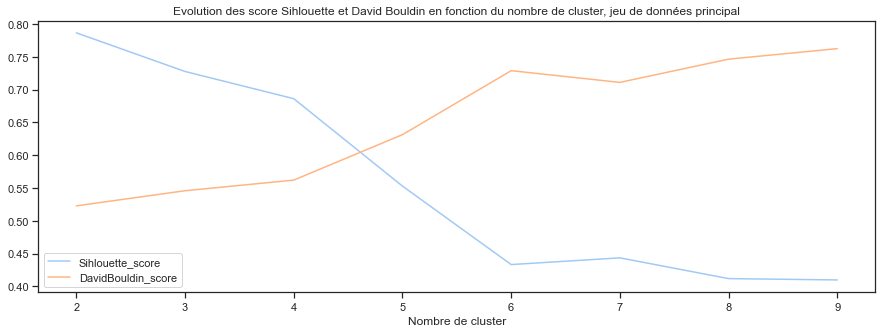

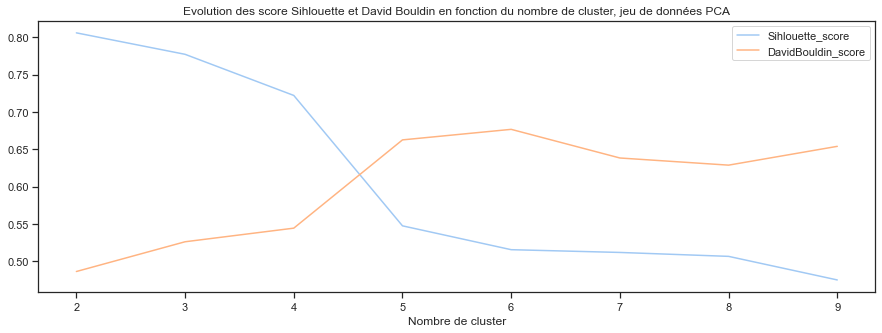

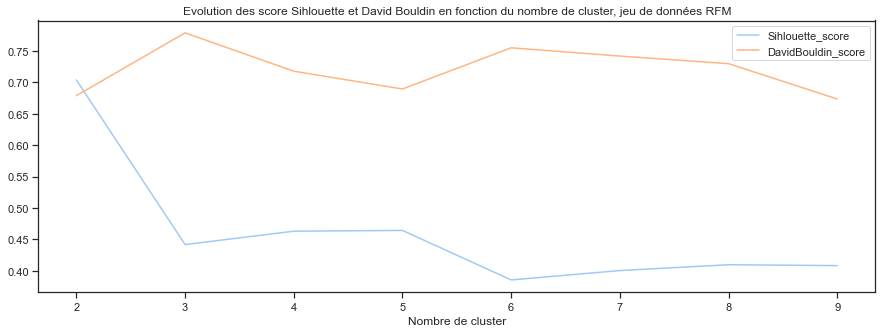

In [169]:
from sklearn.cluster import KMeans
n_cluster(df_, KMeans, 10000, données = 'principal')
n_cluster(df_pca[[0,1]], KMeans, 10000, données = 'PCA')
n_cluster(RFM, KMeans, 10000, données = 'RFM')

In [170]:
import ipywidgets as widgets
from IPython.display import display
from yellowbrick.cluster import SilhouetteVisualizer

@widgets.interact(cluster = (2, 8, 1))
def pca(cluster = 6):
    model = KMeans(cluster)
    visualizer = SilhouetteVisualizer(model, colors = 'yellowbrick')
    visualizer.fit(RFM[:10000])      
    visualizer.show()

interactive(children=(IntSlider(value=6, description='cluster', max=8, min=2), Output()), _dom_classes=('widge…

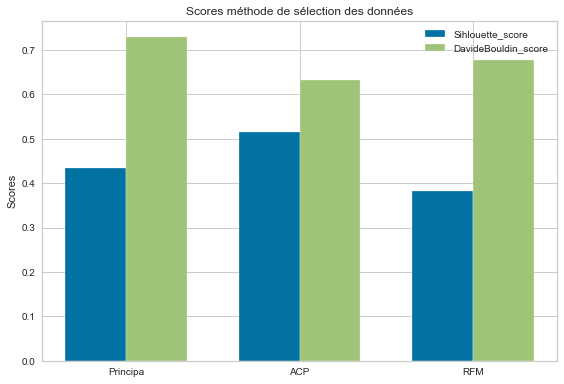

In [239]:
score__ = []
clustering = KMeans(n_clusters = 6)
pred_ = clustering.fit_predict(df_[:10000])
score__.append([silhouette_score(df_[:10000], pred_),
               davies_bouldin_score(df_[:10000], pred_)])

clustering = KMeans(n_clusters = 6)
pred_pca = clustering.fit_predict(df_pca[:10000][[0, 1]])
score__.append([silhouette_score(df_pca[:10000][[0, 1]], pred_pca),
               davies_bouldin_score(df_pca[:10000][[0, 1]], pred_pca)])

clustering = KMeans(n_clusters=6)
pred_rfm = clustering.fit_predict(RFM[:10000])
score__.append([silhouette_score(RFM[:10000], pred_rfm),
               davies_bouldin_score(RFM[:10000], pred_rfm)])

labels = ['Principa', 'ACP', 'RFM']
Sihlouette_score = pd.DataFrame(score__, columns = ['Sihlouette_score','DavideBouldin_score']).Sihlouette_score
DavideBouldin_score = pd.DataFrame(score__, columns = ['Sihlouette_score','DavideBouldin_score']).DavideBouldin_score

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Sihlouette_score, width, label='Sihlouette_score')
rects2 = ax.bar(x + width/2, DavideBouldin_score, width, label='DavideBouldin_score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores méthode de sélection des données')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

In [238]:
pca = PCA(n_components=2)
pca.fit(df_)
print(pca.explained_variance_ratio_)
df_pca = pd.DataFrame(pca.transform(df_))

[0.95381365 0.02898549]


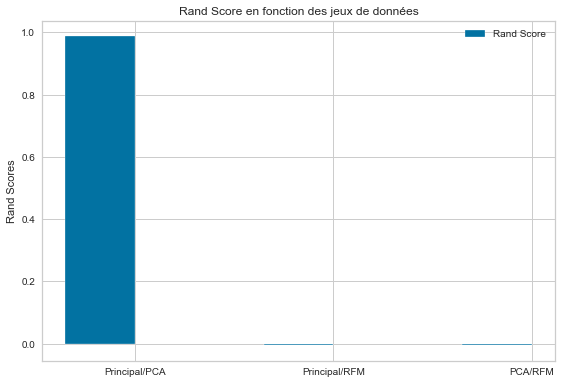

In [241]:
from sklearn.metrics import adjusted_rand_score

labels = ['Principal/PCA', 'Principal/RFM', 'PCA/RFM']
score_rand = [adjusted_rand_score(pred_, pred_pca), 
             adjusted_rand_score(pred_, pred_rfm),
             adjusted_rand_score(pred_pca, pred_rfm)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, score_rand, width, label='Rand Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rand Scores')
ax.set_title('Rand Score en fonction des jeux de données')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

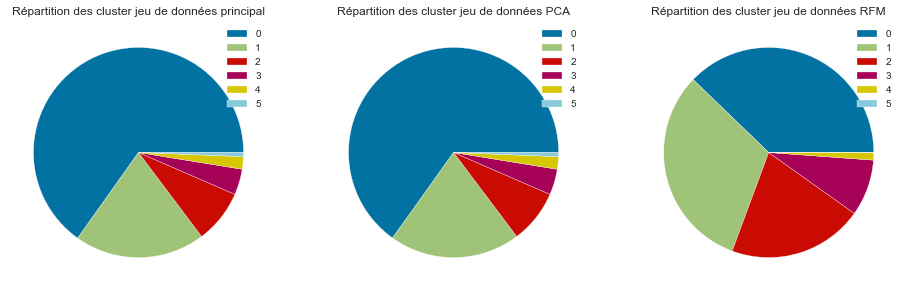

In [242]:
plt.figure(figsize = (16, 10))
plt.subplot(1, 3, 1)
plt.pie(pd.DataFrame(pred_).value_counts())
plt.title('Répartition des cluster jeu de données principal')
plt.legend(range(6))

plt.subplot(1, 3, 2)
plt.pie(pd.DataFrame(pred_pca).value_counts())
plt.title('Répartition des cluster jeu de données PCA')

plt.legend(range(6))

plt.subplot(1, 3, 3)
plt.pie(pd.DataFrame(pred_rfm).value_counts())
plt.title('Répartition des cluster jeu de données RFM')
plt.legend(range(6))
plt.show()

## Comparaison des approches

Text(115.0, 0.5, 'hyper-paramètre : epsilon')

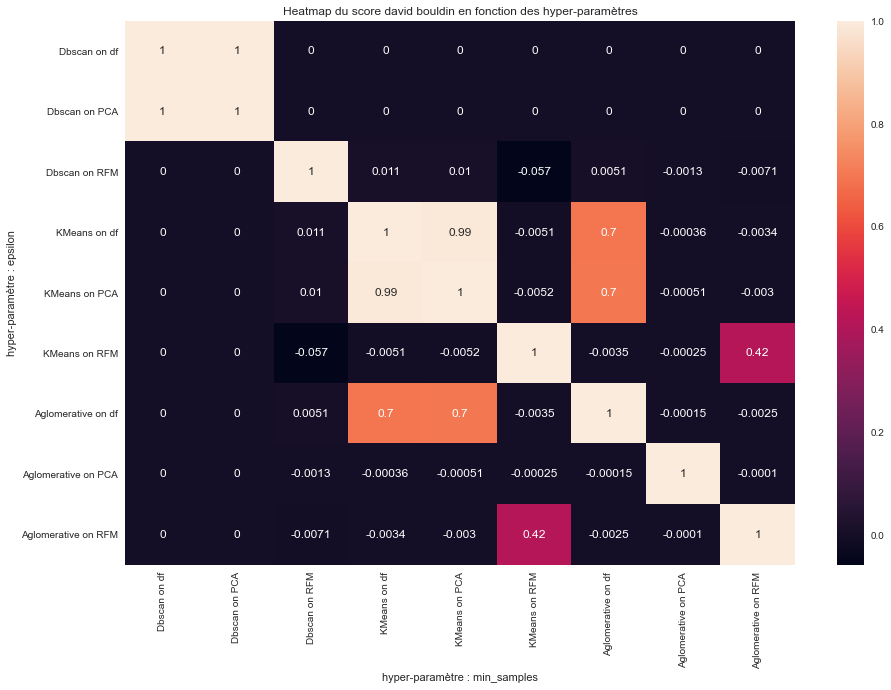

In [245]:
all_pred = [pred_dbscan, pred_pca_dbscan, pred_rfm_dbscan, 
            pred_, pred_pca, pred_rfm, 
            pred_ag, pred_pca_ag, pred_rfm_ag]

matrice_pred = []
for u in all_pred:
    for i in all_pred:
        matrice_pred.append(adjusted_rand_score(u, i))
        
txt = ['Dbscan on df', 'Dbscan on PCA', 'Dbscan on RFM',
       'KMeans on df', 'KMeans on PCA', 'KMeans on RFM',
       'Aglomerative on df', 'Aglomerative on PCA', 'Aglomerative on RFM']

plt.figure(figsize = (15, 10))
sns.heatmap(np.array(matrice_pred).reshape(9, 9),
            annot = True,
            xticklabels = txt,
           yticklabels = txt)
plt.title('Heatmap du score david bouldin en fonction des hyper-paramètres')
plt.xlabel('hyper-paramètre : min_samples')
plt.ylabel('hyper-paramètre : epsilon')

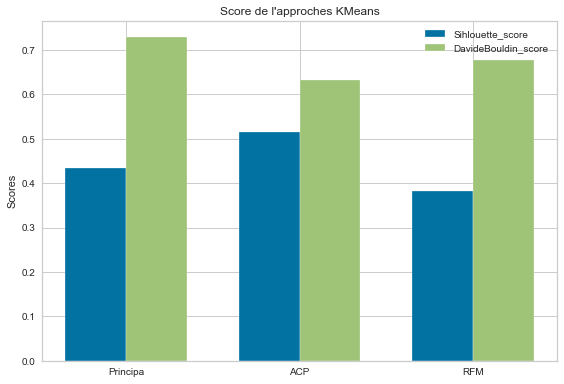

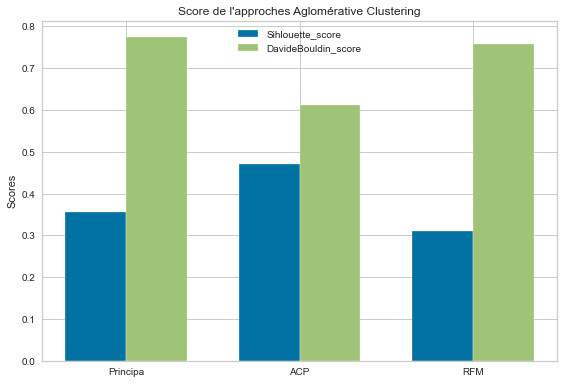

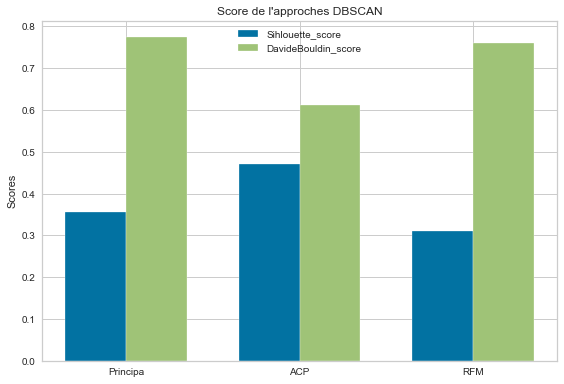

In [273]:
def plot_score(score__, text):
    labels = ['Principa', 'ACP', 'RFM']
    Sihlouette_score = pd.DataFrame(score__, columns=['Sihlouette_score','DavideBouldin_score']).Sihlouette_score
    DavideBouldin_score = pd.DataFrame(score__, columns=['Sihlouette_score','DavideBouldin_score']).DavideBouldin_score

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, Sihlouette_score, width, label='Sihlouette_score')
    rects2 = ax.bar(x + width/2, DavideBouldin_score, width, label='DavideBouldin_score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f"Score de l'approches {text}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

plot_score(score__, 'KMeans')
plot_score(score__ag, 'Aglomérative Clustering')
plot_score(score__dbscan, 'DBSCAN')

# K-Means sur les Datasets ACP et RFM

## Observation des clusters

In [890]:
k_origine = KMeans(n_clusters=5).fit(RFMScores[['Recency','Frequency','Monetary']])
y_test = k_origine.predict(RFMScores[['Recency','Frequency','Monetary']])
Obs_ = RFMScores
Obs_['label'] = y_test

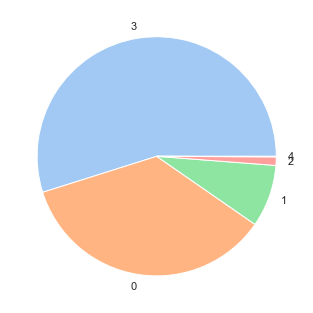

In [891]:
plt.pie(x = Obs_.label.value_counts().values, labels = Obs_.label.value_counts().index)
plt.show()

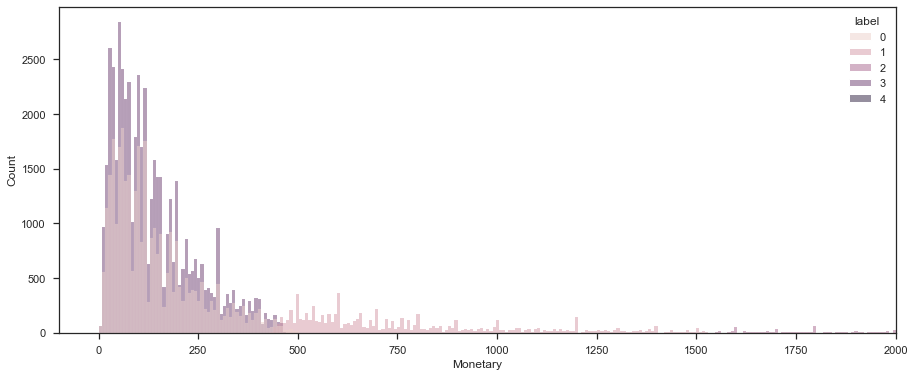

In [892]:
plt.figure(figsize=(15, 6))
sns.histplot(data = Obs_, x = 'Monetary', hue = 'label')
plt.xlim(-100, 2000)
plt.show()

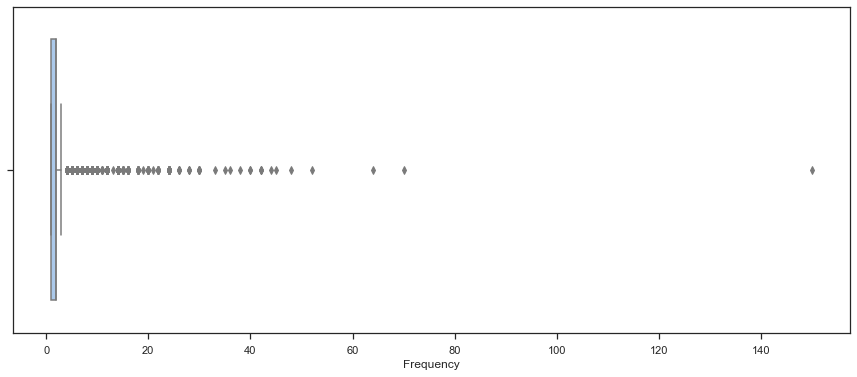

In [899]:
plt.figure(figsize = (15, 6))
sns.boxplot(data = Obs_, x = 'Frequency')
plt.show()

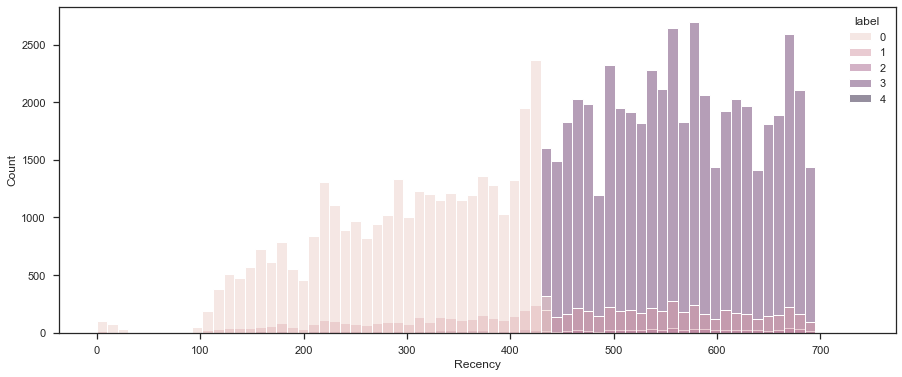

In [894]:
plt.figure(figsize = (15, 6))
sns.histplot(data = Obs_, x = 'Recency', hue = 'label')
plt.show()

## Stabilité des clusters

In [257]:
RFMScores_ = RFMScores.drop(['CustomerID','RFM_Loyalty_Level'], axis=1)
RFMScores_ = pd.concat([RFMScores_,pd.DataFrame(date, columns=['Date'])], axis=1)

def stability(df):
    acc = []

    test_1 = df.sort_values('order_purchase_timestamp').drop(['customer_id','customer_unique_id'], axis =1)
    kmeans = KMeans(n_clusters=5, random_state=0).fit(scaler.fit_transform(RFM))    
    kmeans.fit(test_1)
    y1 = kmeans.labels_


    for u in range(1,10):
        test_2 = df.sort_values('order_purchase_timestamp')[:int(94846/u)].drop(['customer_id','customer_unique_id'], axis =1)
        kmeans = KMeans(n_clusters=5, random_state=0).fit(scaler.fit_transform(RFM))    
        kmeans.fit(test_2)
        y2 = kmeans.labels_

        acc.append(accuracy_score(y1[:int(94846/u)],y2))

        plt.plot(acc)
        
def scoring_stability(RFMScores_,m):
    score = []
    score_sil = []
    score_dv = []
    l = RFMScores_.sort_values('Date')[['Recency','Frequency','Monetary']]
    p = kmeans.predict(l)
    for u in range(1,23):
        n = pred[u].predict(l)
        score.append(adjusted_rand_score(p,n))    
        score_sil.append(silhouette_score(l[:m*1000],n[:m*1000]))
        score_dv.append(davies_bouldin_score(l[:m*1000],n[:m*1000]))
        
    
    plt.figure(figsize=(15,5))
    plt.title('Evolution du Rand score en fonction du nombre de mois')
    plt.xlabel('Nombre de mois')
    plt.ylabel('Rand Score')
    plt.plot(range(1,23),score)
    plt.show()
    
    
    plt.figure(figsize=(15,5))
    plt.title('Evolution du score Silhouette en fonction du nombre de mois')
    plt.xlabel('Nombre de mois')
    plt.ylabel('Sihlouette Score')
    plt.plot(range(1,23),score_sil)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.title('Evolution du score David Bouldin en fonction du nombre de mois')
    plt.xlabel('Nombre de mois')
    plt.ylabel('David Bouldin Score')
    plt.plot(range(1,23),score_dv)
    plt.show()

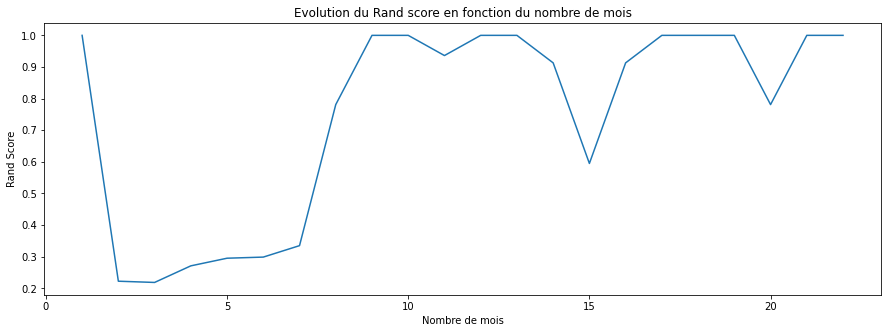

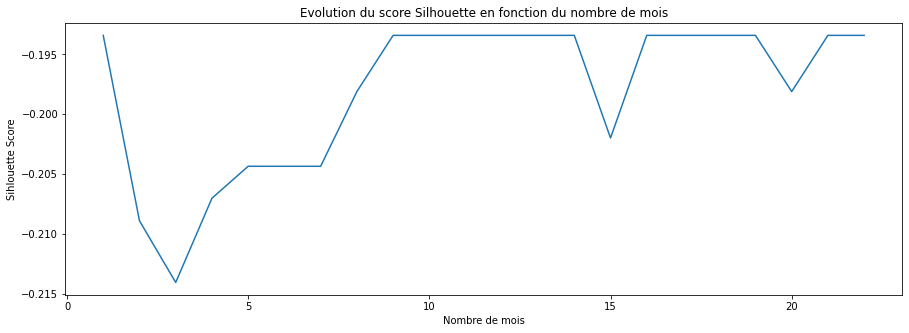

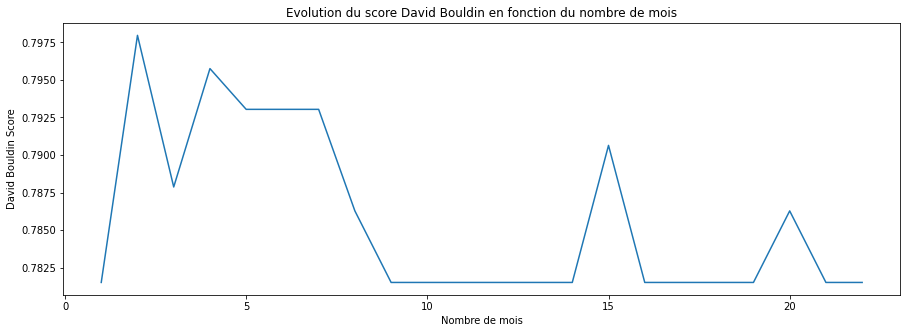

In [36]:
scoring_stability(RFMScores_, 4)

Le clustering est stable à partir de 7 mois

In [816]:
def stability_freq(RFMScores_, n, m):
    x = m
    y = n
    k_origine = KMeans(n_clusters=5).fit(RFMScores_[RFMScores_.Date_m <= 7].drop(['Date_m'], axis = 1))
    y_test = k_origine.predict(RFMScores_[RFMScores_.Date_m <= 7].drop(['Date_m'], axis = 1))
    
    t = [[0 for u in range(n)]for i in range(m)]

    for n in range(y):
        for m in range(x):
            k_t =KMeans(n_clusters=5).fit(RFMScores_[(RFMScores_.Date_m >= 7-n) & (RFMScores_.Date_m <= 7+m)].drop(['Date_m'], axis = 1))
            y_pred = k_t.predict(RFMScores_[RFMScores_.Date_m <= 7].drop(['Date_m'], axis = 1))
            t[m][n] = adjusted_rand_score(y_pred,y_test)

    plt.figure(figsize=(15,10))
    sns.heatmap(np.array(t).T,annot=True,cmap="YlGnBu", yticklabels=-np.arange(y))
    plt.title('Heatmap du nombre de cluster en fonction des hyper-paramètres')
    plt.xlabel('hyper-paramètre : min_samples')
    plt.ylabel("Nobre de mois antécédant avant l'entrainement")
    plt.show()

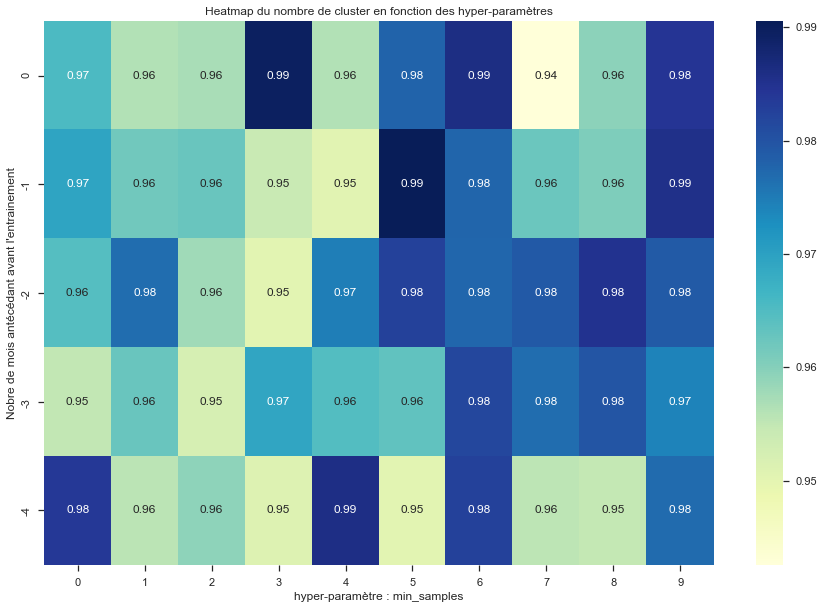

In [817]:
RFMScores_['Date_m'] = RFMScores_['Date']//30
RFMScores_ = RFMScores_.sort_values(('Date_m')).reset_index()

df_['Date_m'] = df_.order_delivered_customer_date//30
df_ = df_.sort_values(('Date_m')).reset_index()

stability_freq(df_pca, 5, 10)

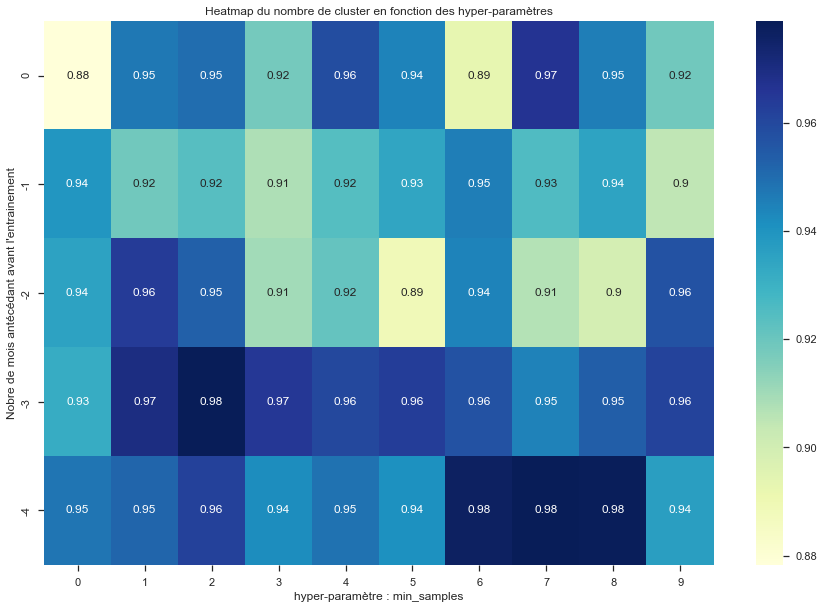

In [825]:
stability_freq(RFMScores_, 5, 10)

## Méthode d'ajout des clusters

# Concusion